João Leme  / email: <leme-joao@hotmail.com> / linkedin: www.linkedin.com/in/joãoleme

# Sumário

* Base de Dados
* Importando Bibliotecas
* Estatística e KDD (Knowledge Data Discovery) 
    - Descritiva
	- Correlação de Pearson
	- Histograma
	- boxplot e qq-plot
	- Distribuiçao (Semanal e mensal)
* Engenharia de Seleção de Recursos
	- Variáveis Continuas 
      + log return
      + media móvel 
	- Variáveis Categóricas 
      + dummy coding
* Limpeza e Adequação
	- Valores faltantes
	- Remoção alta colinearidade
* Treino e teste
* Normalizar e Imputar
* Machine Leaning
	- benchmarking
      + Regressão linear 
      + KNeighborRegressor 
      + Random Forest Regressor
      + Gradient Boosting Regressor
      + Suppot Vector Machine Regressor
      + Rede Neural - MultiLayer Perceptron - MLP
	- Gradient Boosting Regressor
	- Tuning
	- Random Search e Grid Search
	- Treino médio (100 samples)
* Visualização dos Resultados
* Entendendo tomada de decisão do modelo 
    - Feature Importance
    - LIME

# Base de Dados

A base de dados utilizada foi construída utilizando os dados disponibilizados pelo Operador Nacional do Sistema (ONS), que é o principal órgão responsável pela coordenação e controle das instalações de geração e transmissão de energia elétrica no Sistema Interligado Nacional (SIN) e pelo planejamento da operação dos sistemas isolados do país, sob a fiscalização e regulação da Agência Nacional de Energia Elétrica [Aneel](http://www2.aneel.gov.br/aplicacoes/capacidadebrasil/capacidadebrasil.cfm). A ele, cabe decidir a produção energética total que será necessária para atender a demanda nacional.

O ONS desenvolveu uma nova forma de disponibilizar os resultados históricos da operação do SIN, com base nos princípios da transparência e da confiabilidade das informações, sendo estas disponibilizadas em horizonte diário e horário, por subsistemas (Regiões do Brasil), ou pelo total demandado (SIN).

No total, foram utilizados 10 das 15 features disponíveis no site da ONS referente aos anos de 2005 a 2017, sendo constituído por 4748 registros, sob um horizonte diário e em âmbito nacional (SIN). A seguir detalhamos as features empregadas na construção de nossa base de dados:

* Carga(GWh) – Consumo elétrico; 
* DemandaMax – Pico de demanda de carga elétrica; 
* Energia Armazenada (GWh) – Quantidade de Energia Armazenada; 
* Gerado (GWh) – Total gerado por todas as fontes de energia; 
* Intercâmbio(GWh) – Fluxo de potência das linhas de transmissão nas fronteiras; 
* Data – O dia, mês, ano; 
* QAfluente(m^3/s) – Vazão afluente em todos os reservatórios; 
* QVertida(m^3/s) – Vazão vertida em todas hidrelétricas; 
* Volume Útil (%) – Volume total disponível nos reservatórios; 
* Geração Hídrica Geral (GWh) – Total gerado apenas pelas hidrelétricas; 
* Geração Hídrica SE/CO (GWh) – Total gerado pelas hidrelétricas da região SE/CO.

Também, foi adicionada à base informações disponíveis pelo Instituto Nacional de Meteorologia (INMET), que é um órgão federal subordinado ao Ministério da Agricultura, Pecuária e Abastecimento (MAPA) com a missão de prover informações meteorológicas confiáveis à Sociedade Brasileira [INMET](http://www.inmet.gov.br/portal/index.php?r=home2/index).

Em seguida é possível observar a abrangência do SIN, bem como as linhas de transmissão existentes e futuras aquisições.

![SIN](sin.jpg)


# Importando Bibliotecas

In [1]:
#-----------------------------------------------------
# Manipulação e Plots
#-----------------------------------------------------
#Manipulação de dados
import pandas as pd
import numpy as np
from datetime import datetime

# Plots gráficos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.size'] = 2
from IPython.core.pylabtools import figsize
sns.set(font_scale = 2)
plt.style.use('seaborn-whitegrid')
from matplotlib import ticker
from scipy.stats import norm
formatter = ticker.ScalarFormatter(useMathText=True)

# Imputar missing values e Normalização
from sklearn.preprocessing import Imputer, MinMaxScaler

#-----------------------------------------------------
#MACHINE LEARNING
#-----------------------------------------------------

# Seoarar em Treino e Teste
from sklearn.model_selection import train_test_split

# Regressão Linear
from sklearn.linear_model import LinearRegression
# KNR
from sklearn.neighbors import KNeighborsRegressor
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gadient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# svr
from sklearn.svm import SVR
# Rede Neural
from sklearn.neural_network import MLPRegressor

# Função para calcular Erro médio Absoluto
from sklearn.metrics import mean_absolute_error, mean_squared_error

# tuning dos parâmetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# LIME para explicar o modelo
import lime 
import lime.lime_tabular
#-----------------------------------------------------
# Esconder os erros 
import warnings
warnings.filterwarnings('ignore')

Como todos arquivos baixados vem divididos por tópicos em .xlsx, foi feito uma manipulação para adequar os dados na unidade certa e agregalos no mesmo dataset.

In [2]:
data = pd.read_csv('BDONS.csv')

A base se encontra com os labels em inglês (**mudei para fazer um paper pra revista**), logo, será necessário trocar os nome para pt.

In [3]:
data.rename(columns={'relative humidityGeneral':'Umidade Relativa Média','Energy Load':'Consumo Elétrico (GWh)',
                    'VelwindmedGeneral':'Velocidade do Vento Média','Max Demand':'Demanda Máxima',
                    'TmedGeneral':'Temperatura Média','WeekDay':'Dia da Semana',
                    'Stored Energy':'Energia Armazenada (GWh)','Genereted Energy':'Gerado (GWh)',
                    'Power exchange':'Intercâmbio(GWh)','Influent Flow':'QAfluente(m^3/s)',
                    'Water Flow':'QVertida(m^3/s)','Total Volume':'Volume Útil (%)',
                    'Hydroelectric Gen.':'Geração Hídrica Geral (GWh)',
                    'Hydroelectric Gen. SE/CO':'Geração Hídrica SE/CO (GWh)',
                    'Month':'Mês'},inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 16 columns):
Consumo Elétrico (GWh)         4371 non-null float64
Demanda Máxima                 4371 non-null float64
Energia Armazenada (GWh)       4371 non-null float64
Gerado (GWh)                   4371 non-null float64
Intercâmbio(GWh)               4371 non-null float64
Data                           4371 non-null object
QAfluente(m^3/s)               4371 non-null float64
QVertida(m^3/s)                4371 non-null float64
Volume Útil (%)                4371 non-null float64
Geração Hídrica Geral (GWh)    4371 non-null float64
Geração Hídrica SE/CO (GWh)    4371 non-null float64
Temperatura Média              4371 non-null float64
Umidade Relativa Média         4371 non-null float64
Velocidade do Vento Média      4371 non-null float64
Dia da Semana                  4371 non-null int64
Mês                            4371 non-null int64
dtypes: float64(13), int64(2), object(1)
memory us

# Estatística e KDD - Knowledge Data Discovery

Manipulação para melhor visualização dos dados

In [5]:
# tranformar coluna do tipo Object para DateTime
data['Data'] = pd.to_datetime(data['Data'])
# Mes de 0,1,2 para January, February...
data['Mês'] = data["Data"].dt.strftime("%B")


## Estatística Descritiva

Nos permite resumir, descrever e compreender os dados de
uma distribuição usando medidas de tendência central (média, mediana e
moda), medidas de dispersão (valores mínimo e máximo, desvio padrão e
variância), percentis, quartis e medidas de distribuição (achatamento e simetria da
curva de distribuição)

In [6]:
data.describe()

Consumo Elétrico (GWh)  Demanda Máxima  Energia Armazenada (GWh)  \
count             4371.000000     4371.000000               4371.000000   
mean              1330.867297    65787.927148             116055.319648   
std                180.450623     7068.462742              37731.900292   
min                856.563420    46529.800000              37762.467000   
25%               1195.962023    60291.760000              85055.402250   
50%               1318.769659    65463.340000             117644.103000   
75%               1470.252473    70931.355000             150226.229250   
max               1804.522402    85707.980000             186491.536500   

       Gerado (GWh)  Intercâmbio(GWh)  QAfluente(m^3/s)  QVertida(m^3/s)  \
count   4371.000000       4371.000000       4371.000000      4371.000000   
mean    1332.413761         12.588812        879.659005       906.144885   
std      179.020684         93.681016        264.937695       274.588847   
min      872.950159       -206.576663        408.534710       413.160719   
25%     1198.590762        -65.279944        667.796157       693.450372   
50%     1322.397917          9.844424        825.700526       849.620565   
75%     1469.579570         91.676654       1058.630248      1087.878360   
max     1806.649459        232.950840       1925.443566      2012.479310   

       Volume Útil (%)  Geração Hídrica Geral (GWh)  \
count      4371.000000                  4371.000000   
mean         62.556948                  1110.554350   
std          12.072768                   133.719442   
min          30.323971                   672.793181   
25%          53.694265                  1023.968304   
50%          62.738750                  1115.809890   
75%          72.001259                  1199.676795   
max          88.384844                  1490.105759   

       Geração Hídrica SE/CO (GWh)  Temperatura Média  Umidade Relativa Média  \
count                  4371.000000        4371.000000             4371.000000   
mean                    700.650400          20.016475               63.947337   
std                      86.529237           1.832352                5.952552   
min                     434.745049          14.091111               43.250000   
25%                     641.398919          18.590000               60.250000   
50%                     710.376260          20.340000               64.833333   
75%                     760.940769          21.448889               68.333333   
max                     947.959384          24.737778               78.944444   

       Velocidade do Vento Média  Dia da Semana  
count                4371.000000    4371.000000  
mean                    1.412083       2.981698  
std                     0.278185       1.997741  
min                     0.574074       0.000000  
25%                     1.220841       1.000000  
50%                     1.396296       3.000000  
75%                     1.587364       5.000000  
max                     3.066667       6.000000

Analisando apenas o describe da variável target (**Consumo Elétrico GWh**)
* Ao conduzir a análise do coeficiente de variação, que é a relação entre o desvio padrão e a média, tem-se que a 
  porcentagem obtida foi de 13,39%, o que nos indica que a variação do consumo de eletricidade no Brasil é homogênea, 
  ou seja, segue uma distribuição estável.
* Através dos máximos e mínimos das variáveis alvo. Temos que a variação entre estes (supostamente) parece ser normal, variando na ordem de 3 a 4 vezes o valor do desvio padrão acima ou abaixo da média. 
* Também é possível constatar que a média e a mediana (quartil 50%) encontram-se próximas, o que indica uma boa simetria na distribuição.

## Correlação de Pearson

A determinação do grau de relação entre duas variáveis é dada pelo coeficiente de Pearson, também chamado de coeficiente de correlação, ou simplesmente correlação para os pares de variáveis. Este coeficiente, normalmente representado por ρ, assume apenas valores entre -1 e 1, que expressa o grau de dependência linear entre duas variáveis quantitativas. 

* (+/-) 0,9 correlação muito forte.
* (+/-) 0,7 a 0,9 correlação forte.
* (+/-) 0,5 a 0,7 correlação moderada.
* (+/-) 0.3 a 0,5 correlação fraca.
* (+/-) 0 a 0,3 correlação desprezível.


* Geral

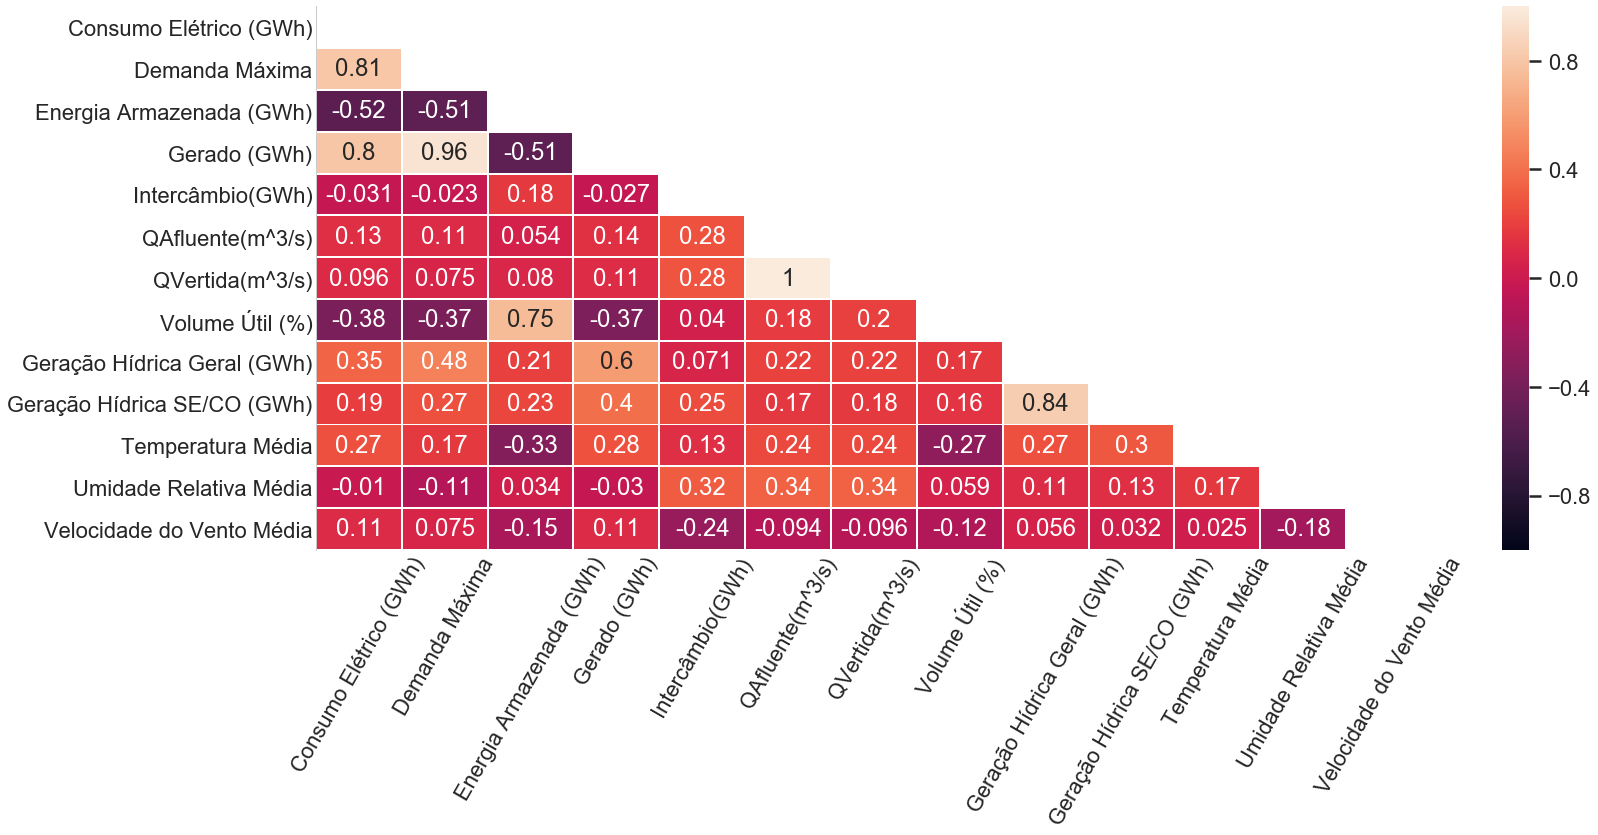

In [7]:
# Excluindo colunas do mes e dia semana para correlação
correlations_data = data.drop(['Dia da Semana','Mês'],axis=1).corr()
matrix = np.triu(correlations_data)
# plotando
f, ax = plt.subplots(figsize=(25,10))
plt.style.use('seaborn-notebook')
sns.set_context('poster',font_scale=1)
sns.set_color_codes("pastel")
ax = sns.heatmap(correlations_data, annot=True, linewidths=1, mask=matrix, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
sns.despine(left=False, bottom=True)

* Correlação com Consumo Elétrico

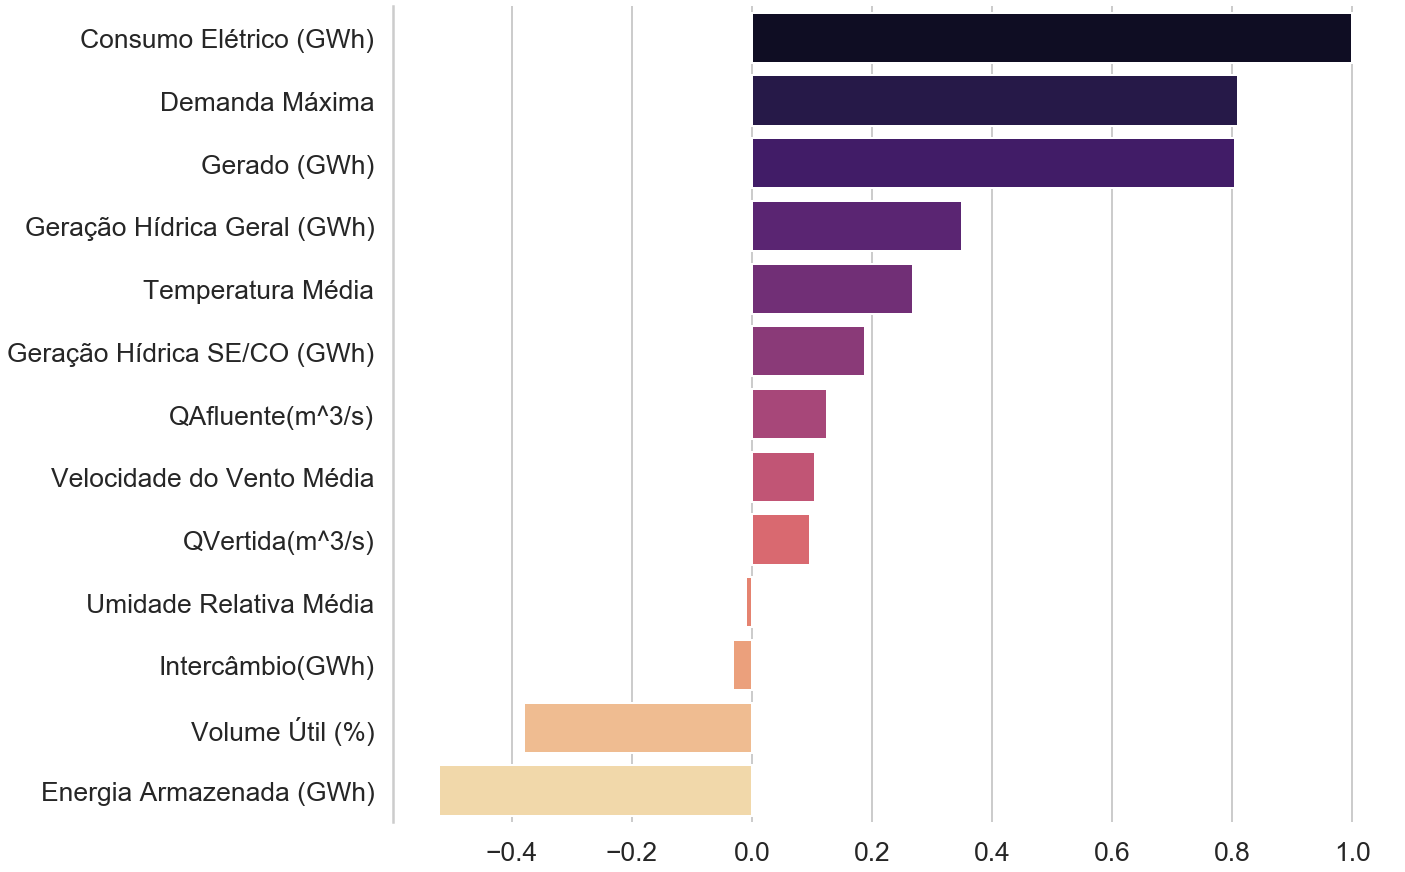

In [8]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 15))
correlations_data = data.drop(['Dia da Semana','Mês'],axis=1).corr()['Consumo Elétrico (GWh)'].sort_values(ascending=False)
sns.barplot(x=correlations_data.values, y=correlations_data.keys(), palette='magma')
axes.set(ylabel="", xlabel="")
sns.despine(left=False, bottom=True)


* Pairplot entre as Consumo, Geração  Hídrica, Vazão Afluente e E armazenada.

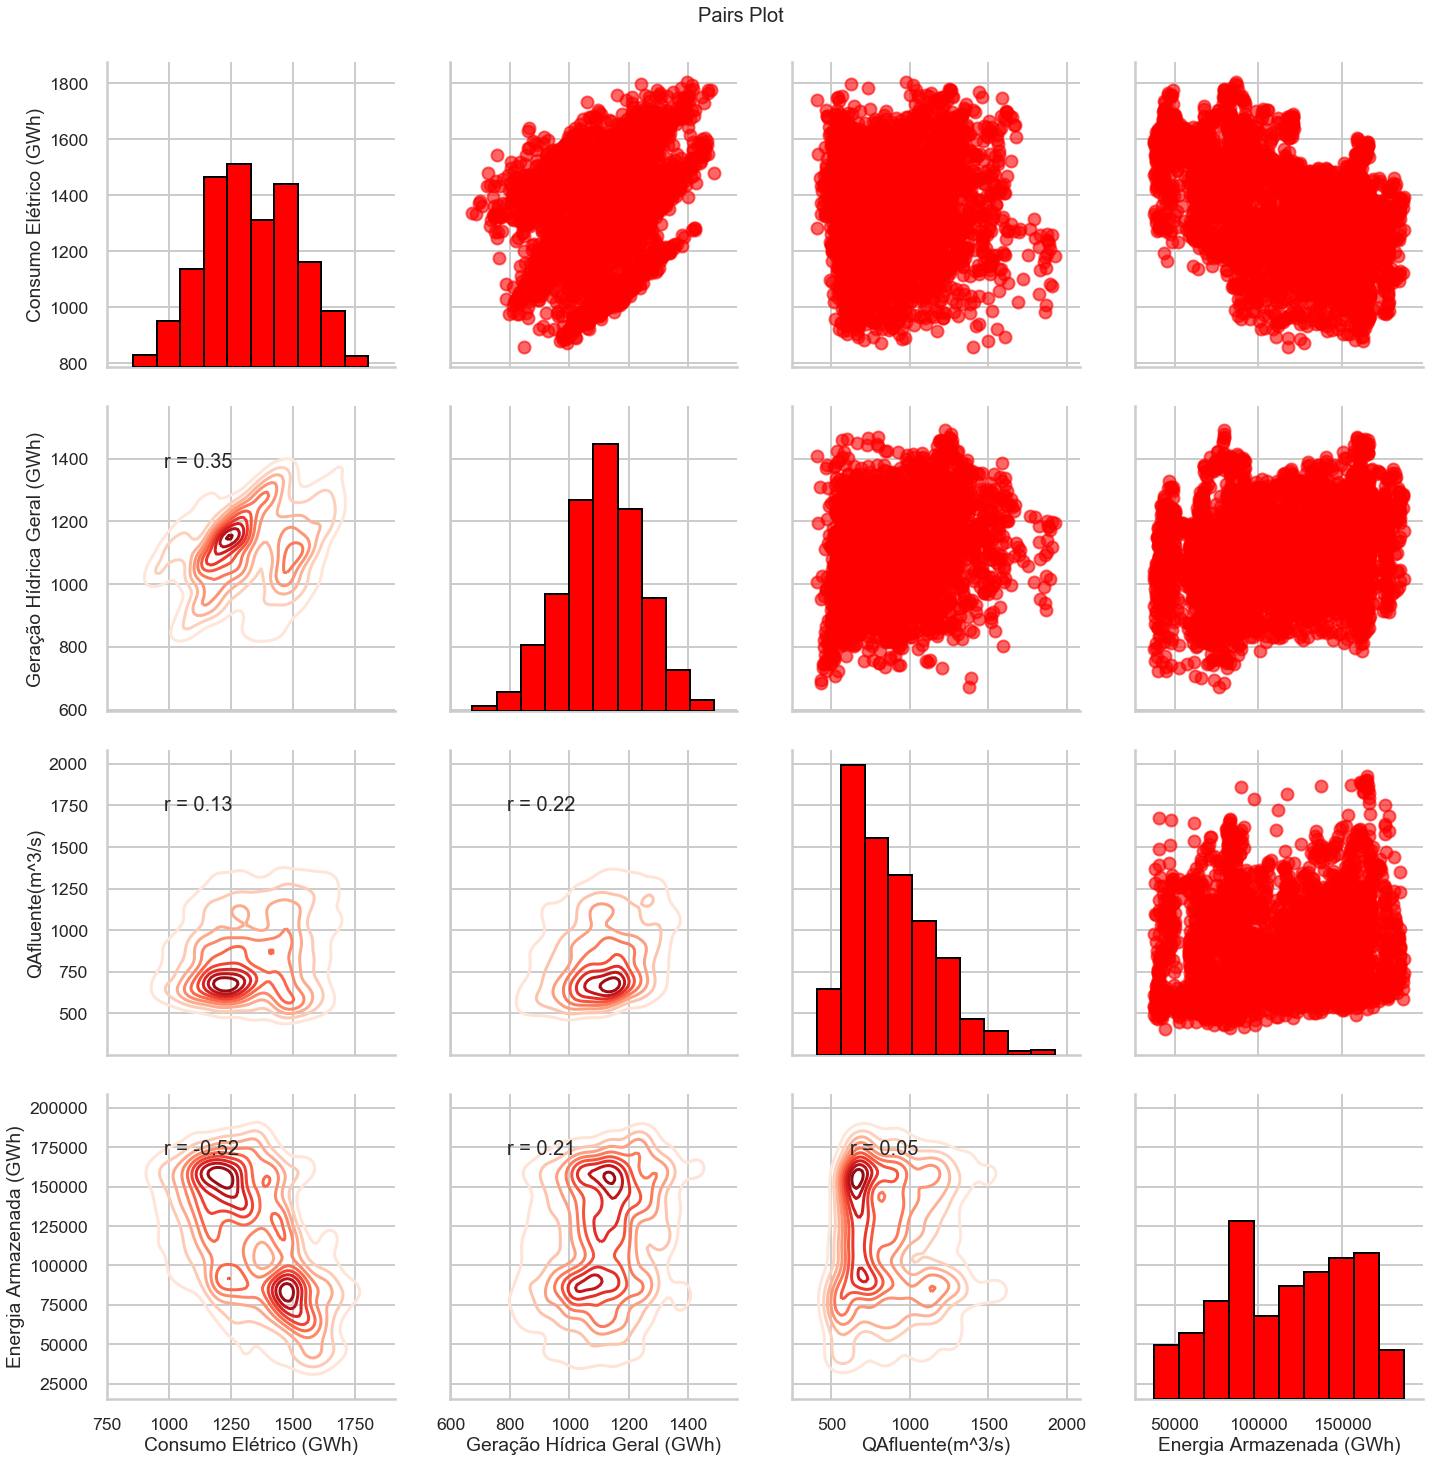

In [9]:
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=0.8
               )
# Colunas para plotar
plot_data = data[['Consumo Elétrico (GWh)', 'Geração Hídrica Geral (GWh)', 
                      'QAfluente(m^3/s)','Energia Armazenada (GWh)']]

# substituindo inf para nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})


# Drop na 
plot_data = plot_data.dropna()

# calcula correlações entre as colunas
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Criando pairgrid object
grid = sns.PairGrid(data = plot_data, size = 5)

# upper é scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# diagonal é um histograma
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# A baixo a correlação e o density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Título
plt.suptitle('Pairs Plot', size = 20, y = 1.02);

Como é possível observar, algumas features tem correlações muito alta, o que é um problema para os futuros modelos de predição. Assim, na etapa de Limpeza dos dados será retirado tais features colineares.
* correlação positiva -> (diretamente proporcional) com o Consumo (GWh) são as que tem alguma derivação da mesma, como a Demanda máxima de consumo em um dado dia; A energia gerada (Gerado) para suprir esse consumo (Carga), as quais são grandezas dependentes, e a Geração Hídrica Geral, já que é a fonte hidrelétrica que compõe a matriz nacional de geração em 60,32%. 
* correlação negativa -> (inversamente proporcional) com o Consumo (GWh), a de menor correlação é a Energia Armazenada


## Histograma

O histograma, também conhecido como distribuição de frequências, é a representação gráfica em colunas ou em barras (retângulos) de um conjunto de dados previamente tabulado e dividido em classes uniformes ou não uniformes. Sendo assim, este mostra graficamente como cada categoria (intervalo) é responsável pela proporção do total de observações e sua apropriação 

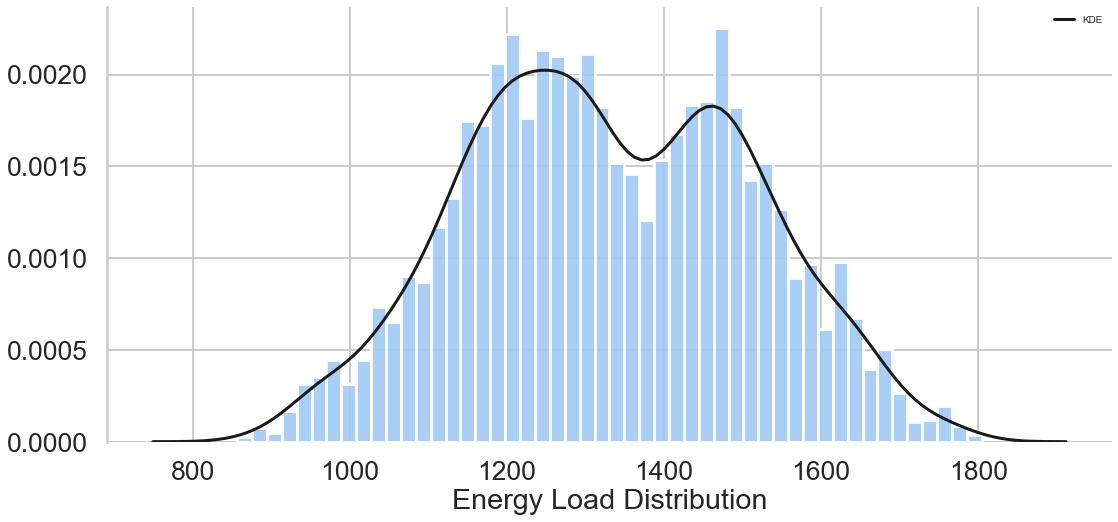

In [10]:
#Configurações de plot
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
fig, axes = plt.subplots(figsize=(18, 8))
plt.style.use('seaborn-notebook')
sns.set_color_codes("pastel")
#plot seaborn
sns.distplot(data['Consumo Elétrico (GWh)'],50,norm_hist=True,kde_kws={"color": "k", "lw": 3, "label": "KDE"},
         hist_kws={"linewidth": 3,"alpha": 0.9, "color": "b"})

axes.set(ylabel="", xlabel="Energy Load Distribution")
sns.despine(left=False, bottom=True)

[Text(0, 0.5, 'Consumo Elétrico (GWh)'), Text(0.5, 0, 'Dias')]

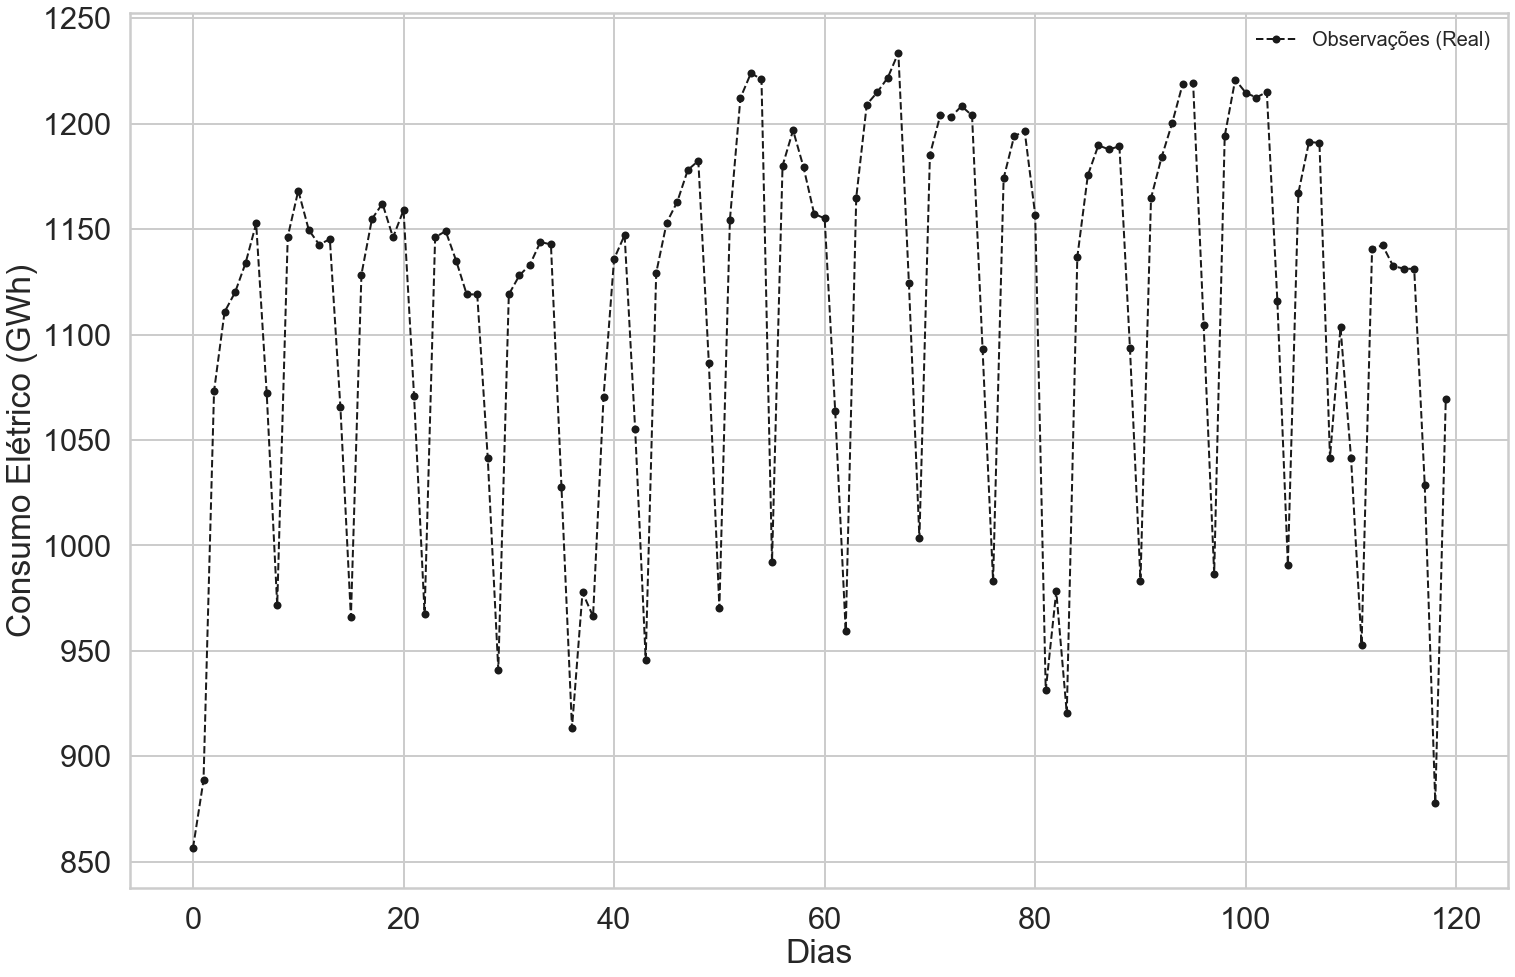

In [73]:
plt.style.use('seaborn-notebook')
sns.set_context('poster',font_scale=1.4)
fig, axes = plt.subplots(figsize=(22, 15))

#horizonte das predições
horizonte = 120

axes.yaxis.set_major_formatter(formatter) 
plt.plot(data['Consumo Elétrico (GWh)'][:horizonte], color='k',markersize=8,marker='o', lw=2, linestyle='dashed',label='Observações (Real)')

plt.legend(loc='best', fontsize=20)
axes.set(ylabel="Consumo Elétrico (GWh)", xlabel="Dias")

É possível constatar que o consumo de eletricidade no Brasil encontra-se com maior frequência em dois picos de quase mesma densidade, contudo, com dispersões diferentes. 
* Primeiro pico -> está localizado próximo aos valores médio e mediano da variável.  Desse modo, pode-se afirmar que durante um determinado período do ano o consumo de eletricidade encontra-se nesse pico, onde o consumo é menor. 
* Segundo pico -> se encontra próximo ao valor da média mais o desvio padrão, que abrange o quartil 75%. Assim, esse pico pode ser relacionado aos momentos de pico de demanda, principalmente em períodos de crise hídrica.

## BoxPlot e QQ-Plot

O histograma, também conhecido como distribuição de frequências, é a representação gráfica em colunas ou em barras (retângulos) de um conjunto de dados previamente tabulado e dividido em classes uniformes ou não uniformes. Sendo assim, este mostra graficamente como cada categoria (intervalo) é responsável pela proporção do total de observações e sua apropriação.

O boxplot é uma ferramenta gráfica para representar a variação de dados observados de uma variável numérica por meio de quartis e podem ser utilizados para identificar possíveis outliers

O gráfico Quantil-Quantil (Q-Q Plot) é um gráfico de probabilidades que compara os valores ordenados de uma variável com quantis de uma distribuição teórica específica (isto é, a distribuição normal).

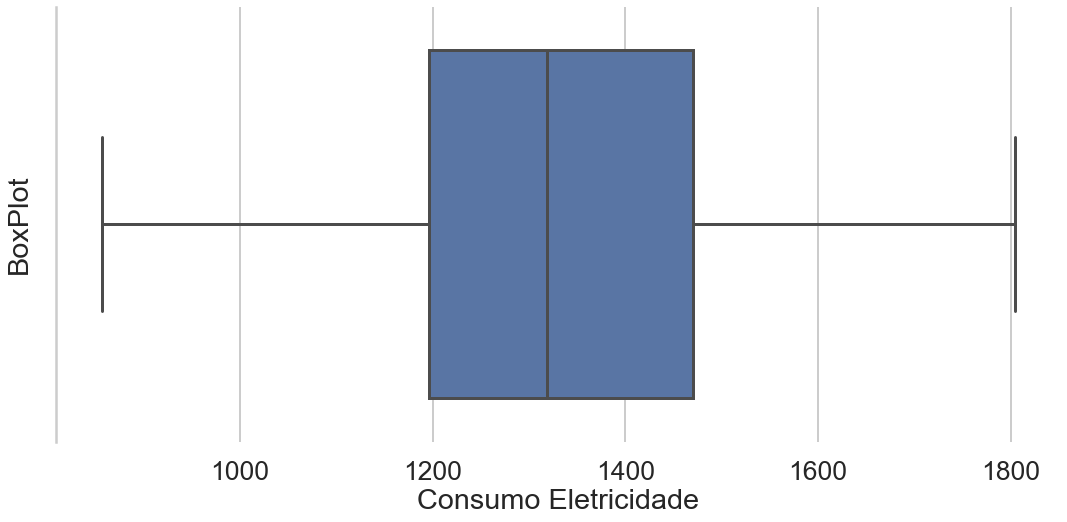

In [11]:
import scipy.stats as stats

formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 8))
sns.boxplot(x='Consumo Elétrico (GWh)',data=data)
axes.set(ylabel="BoxPlot", xlabel="Consumo Eletricidade")
sns.despine(left=False, bottom=True)

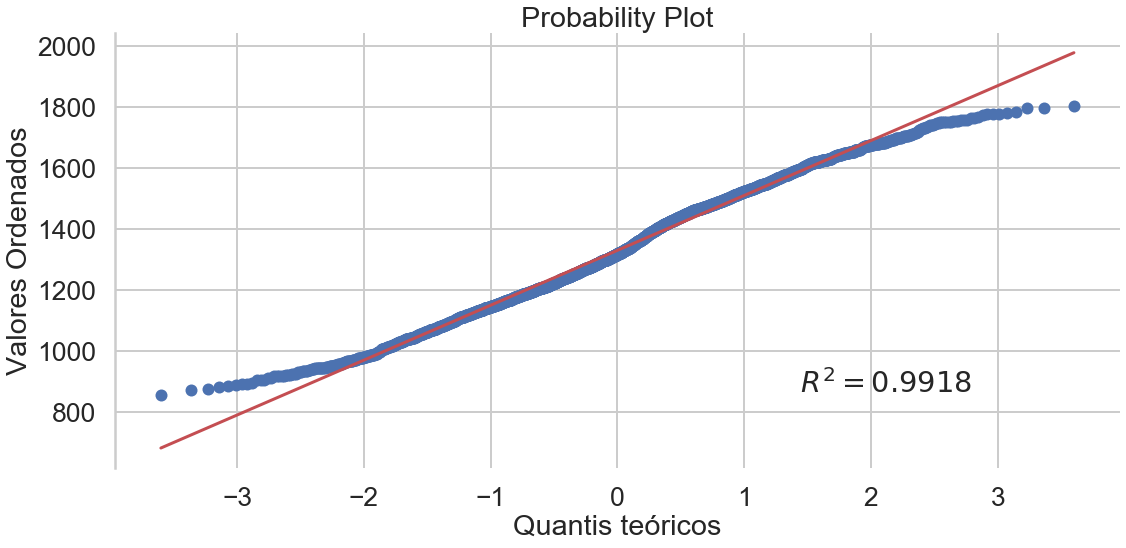

In [12]:
import scipy.stats as stats

formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 8))
stats.probplot(data['Consumo Elétrico (GWh)'], dist='norm', plot=plt,rvalue=True)
axes.set(ylabel="Valores Ordenados", xlabel="Quantis teóricos")
sns.despine(left=False, bottom=True)

* Boxplot -> distribuição da variável Carga não possui valores discrepantes, logo, não apontando outliers que possam gerar ruídos na distribuição.
* Q-Q Plot -> é possível averiguar que há uma alta relação linear entre as distribuições dos quartis, tanto visualmente, ao observar os valores acima da reta, como através do coeficiente de determinação, que é de 0,9928.

## Distribuição da var target (Consumo Elétrico) [semana, mês]

* Semana

1 – Segunda-Feira; 2 – Terça-Feira; 3 – Quarta-Feira; 4 -
Quinta-Feira; 5– Sexta-Feira; 6 – Sábado; 0 – Domingo)

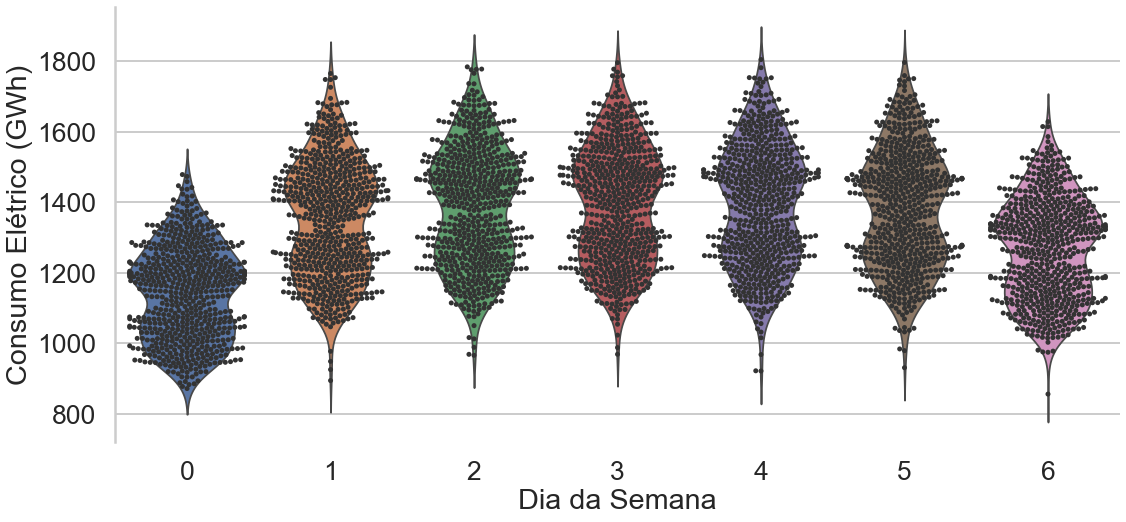

In [13]:
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 8))
plt.style.use('seaborn-notebook')
sns.set_color_codes("pastel")

sns.swarmplot(x="Dia da Semana", y="Consumo Elétrico (GWh)", data=data,color=".2")
sns.violinplot(x="Dia da Semana", y="Consumo Elétrico (GWh)", data=data, inner=None)

axes.set(ylabel="Consumo Elétrico (GWh)", xlabel="Dia da Semana")
sns.despine(left=False, bottom=True)

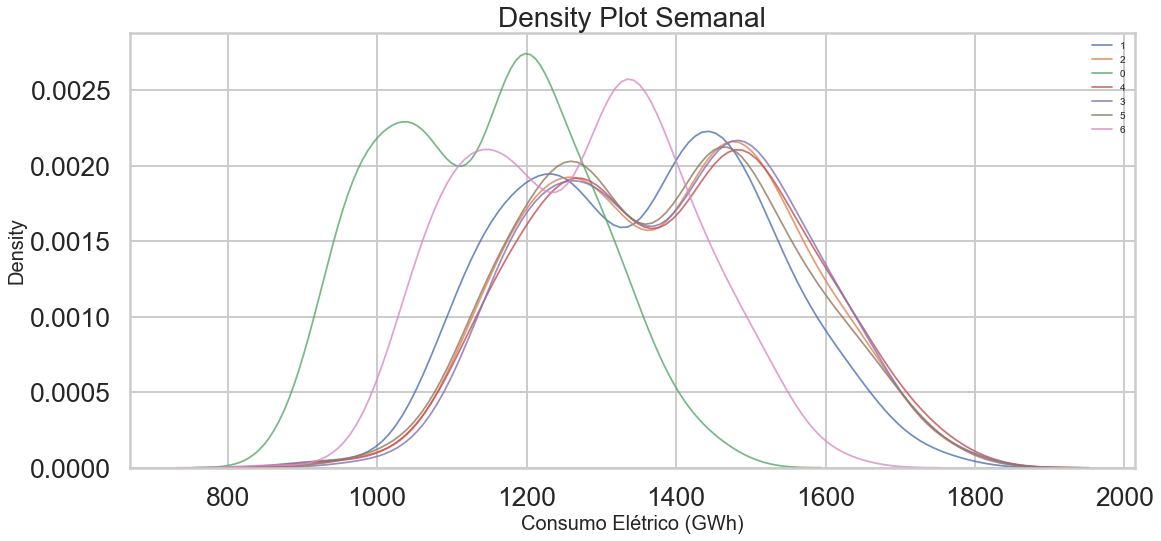

In [14]:
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 8))
plt.style.use('seaborn-notebook')
sns.set_color_codes("pastel")
# Plotando cada categori
types = data['Dia da Semana'].value_counts()
types = list(types.index)
for b_type in types:
    # Percorre e seleciona cada categoria
    subset = data[data['Dia da Semana'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['Consumo Elétrico (GWh)'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Consumo Elétrico (GWh)', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot Semanal', size = 28);

* Mês

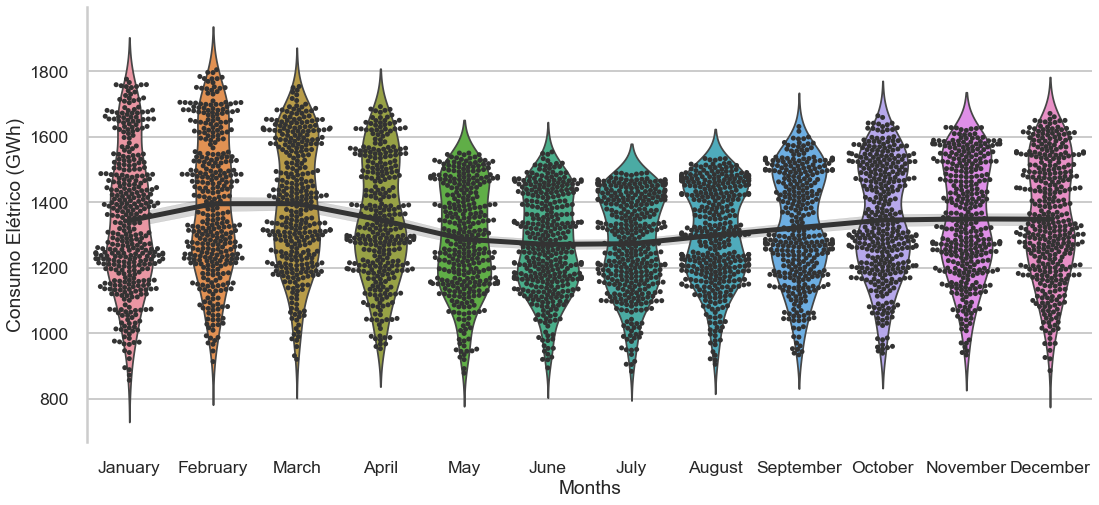

In [15]:
from matplotlib import ticker
from scipy.stats import norm
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=0.8)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 8))
plt.style.use('seaborn-notebook')
sns.set_color_codes("pastel")

sns.swarmplot(x="Mês", y="Consumo Elétrico (GWh)", data=data,color=".2")
sns.lineplot(x="Mês", y="Consumo Elétrico (GWh)", data=data,lw=5,palette='magma',sort=False,color=".2")
sns.violinplot(x="Mês", y="Consumo Elétrico (GWh)", data=data, inner=None)

axes.set(ylabel="Consumo Elétrico (GWh)", xlabel="Months")
sns.despine(left=False, bottom=True)

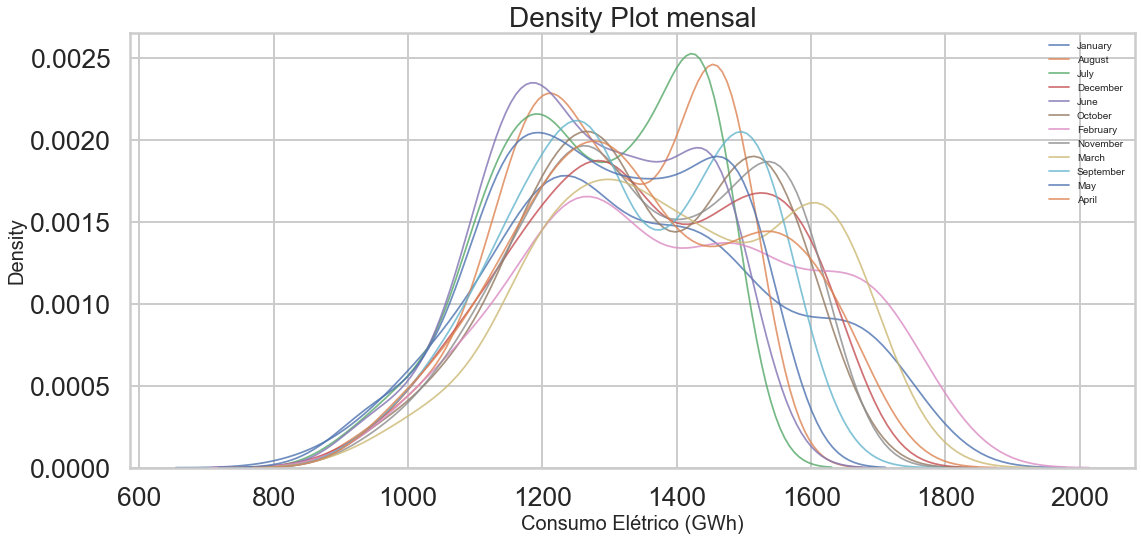

In [16]:
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 8))
plt.style.use('seaborn-notebook')
sns.set_color_codes("pastel")
# Plotando cada categori
types = data['Mês'].value_counts()
types = list(types.index)
for b_type in types:
    # Percorre e seleciona cada categoria
    subset = data[data['Mês'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['Consumo Elétrico (GWh)'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Consumo Elétrico (GWh)', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot mensal', size = 28);

* Distribuição dos meses

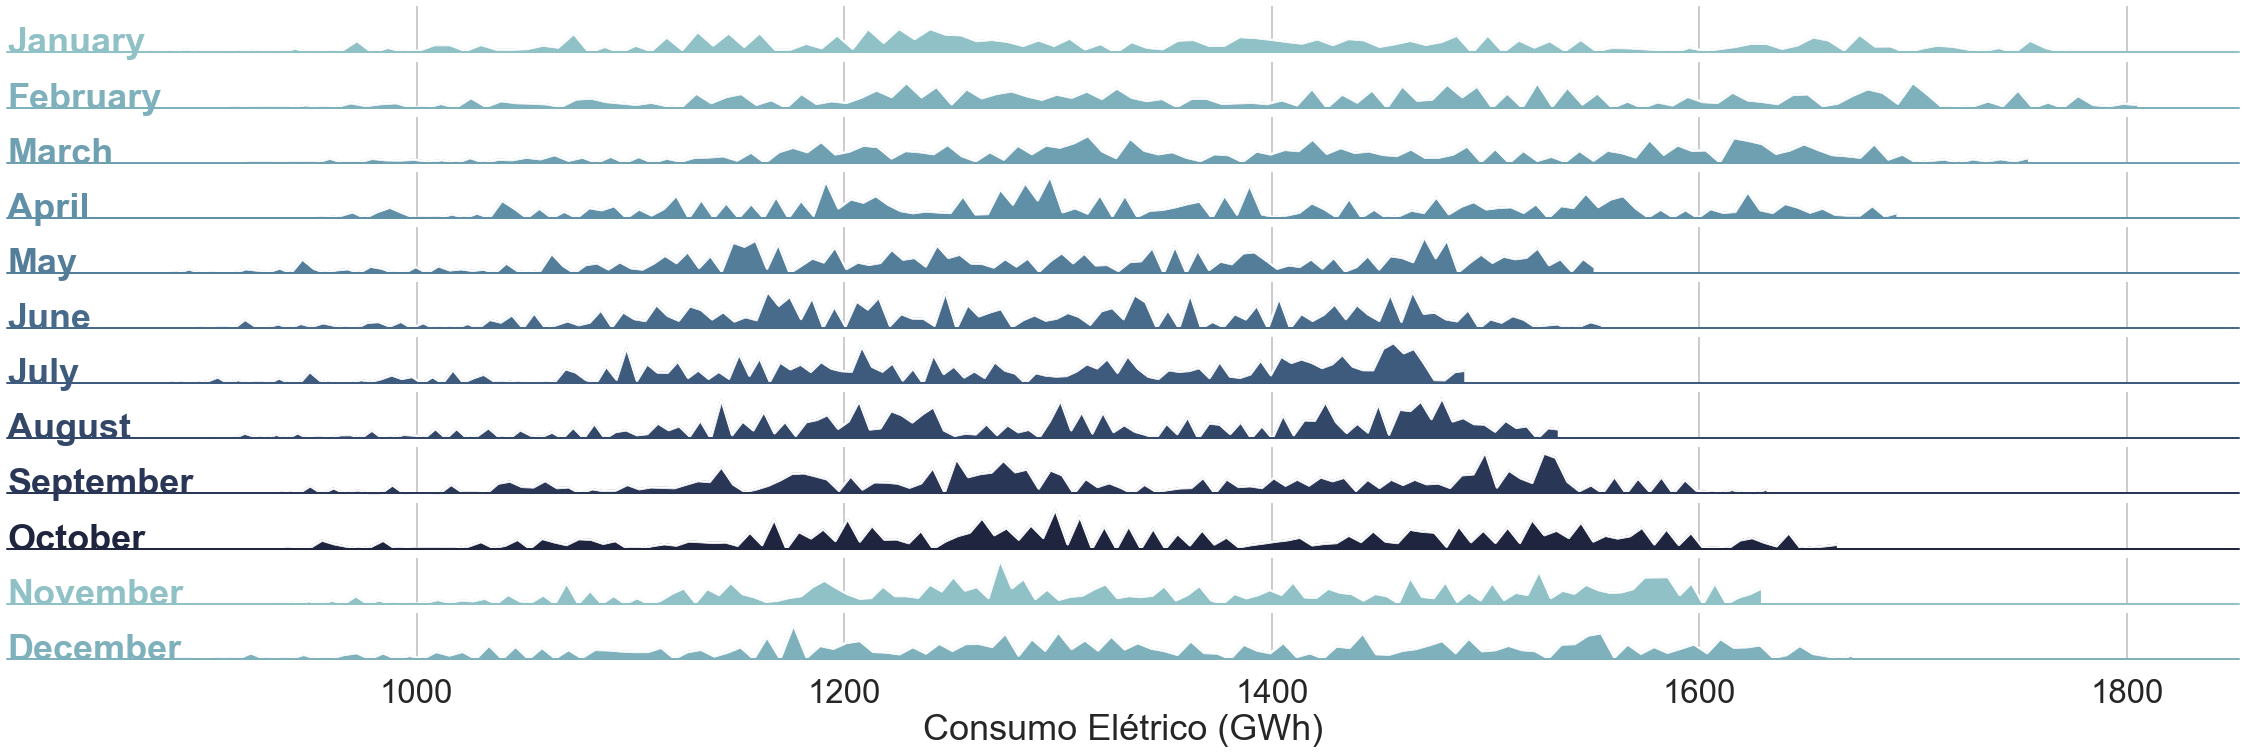

In [17]:
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.5)

# Inicializa o FacetGrid object
x=data['Consumo Elétrico (GWh)']

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data, row="Mês", hue="Mês", aspect=40, height=1, palette=pal)

# Plot das densidades por mes
g.map(sns.kdeplot, "Consumo Elétrico (GWh)", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "Consumo Elétrico (GWh)", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Função simples para colocar as cordenadas dos labels 
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Consumo Elétrico (GWh)")

# Setando os subplots 
g.fig.subplots_adjust(hspace=+.2)

# Remover alguns detalels das axes
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

* Semanal -> Maior nos dias úteis, provavelmente pelo funcionamento das indústrias durante a semana.
* Mensal -> Meses de maior consumo são: Janeiro, Fevereiro e Março. Estes meses correspondem à estação verão e a transição para o outono no Brasil.

# Engenharia e Seleção de Recursos

Em estatística, define-se variável como a característica dos elementos da amostra de dados que nos interessa averiguar. Basicamente, as variáveis podem ser subdivididas em dois grupos: variáveis contínuas e categóricas. 
As variáveis contínuas são aquelas que podem assumir qualquer valor num certo intervalo (contínuo) da reta real. Não é possível enumerar todos os possíveis valores. Essas variáveis, geralmente, provêm de medições. Já as variáveis categóricas são aquelas que podem assumir apenas valores inteiros em pontos da reta real. É possível enumerar todos os possíveis valores da variável. Exemplo: Número de alunos de uma escola, número de mensagens em uma secretária eletrônica, etc.
A engenharia de recursos consiste no processo de formular os recursos mais apropriados quanto aos dados, modelo, e tarefa pretendida, já que, se não houver variáveis informativas suficientes, o modelo de AM pode não executar a tarefa de forma satisfatória. Se houver muitas variáveis, ou se a maioria delas for irrelevante, o modelo será mais caro computacionalmente, além de mais complicado de treinar.


## Variáveis Contínuas 

### Log_return da var target

O benefício da utilização da variação é a normalização. A transformação das variáveis em uma métrica comparável, nesse caso em porcentagem, permite avaliar as relações analíticas entre duas ou mais variáveis, apesar de se originar de séries de valores desiguais. Este é um requisito para muitas análises estatísticas multidimensionais e técnicas de aprendizado de máquina.


In [18]:
data['Consumo_log_return'] = (np.log(data['Consumo Elétrico (GWh)'].shift(1)) - np.log(data['Consumo Elétrico (GWh)'].shift(2)))

### Média Móvel - Semanal e Mensal

Em estatística, a média móvel é um recurso utilizado para se identificar a tendência de um conjunto de dados dispostos em uma série temporal. Dados e informações de séries temporais variam segundo uma série de eventos ao longo do tempo. Embora seja muito difícil identificar exatamente os fatores que afetam o movimento desses dados, podemos quase sempre identificar uma tendência ao longo de períodos. Ou seja, ela é utilizada para se entender para qual caminho os dados parecem apontar; se vai seguir uma tendência de alta, se vai cair ou se permanecerá estacionário, bem como suavizar os movimentos da variável em questão, retirando os ruídos, representados pelas oscilações mais fortes. Com isso torna-se mais simples entender o comportamento de uma variável

* Simples

In [19]:
data['MMS Semanal'] = data['Consumo Elétrico (GWh)'].rolling(window=7).mean()
data['MMS Mensal'] = data['Consumo Elétrico (GWh)'].rolling(window=30).mean()

* Exponencial

In [20]:
data['MME Semanal'] = data['Consumo Elétrico (GWh)'].ewm(span=7, adjust=False).mean()
data['MME Mensal'] = data['Consumo Elétrico (GWh)'].ewm(span=30, adjust=False).mean()

OBS: Poderia também ser utilizado o recurso Polynomial Features [sklearn - Poly Features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), contudo, não foi implementado neste projeto.

## Variáveis Categóricas

Existem diversas alternativas propostas para contornar esse problema, como o One-Hot Enconding, Effect Coding, Sum coding, Polynomail Coding, Dummy Coding, etc. Dentre estas, a utilizada neste projeto foi a Dummy Coding, logo, tal metodologia será discutida a seguir. 

Um método mais adequado do que usar dados numéricos é utilizar um grupo de bits. Cada bit representa uma categoria possível. Se a variável não puder pertencer a várias categorias de uma só vez, apenas um bit no grupo poderá estar "ativado". Cada um dos bits é um recurso. Portanto, uma variável categórica com k categorias possíveis é codificada como um vetor de característica de comprimento k-1.

In [21]:
data['Data'] = pd.to_datetime(data['Data'])
# Mes de 0,1,2 para January, February...
data['Mês'] = data["Data"].dt.strftime("%B")
# Dia da Semana de 0 = monday, 1= thuesday para mondey, thuesday...
data['Dia da Semana'] = data["Data"].dt.strftime("%A")

categorical_subset = data[['Dia da Semana', 'Mês']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Juntando os dataframes com concat
data = pd.concat([data, categorical_subset], axis = 1)

del data['Dia da Semana']
del data['Mês']
del data['Data']

# Limpeza e Adequação 

## Valores Faltantes 

Como visto anteriomente, não há dados faltantes na base de dados original, contudo, após a engenheria de recurso tal observação pode ter sido alterada.
A seguir se encontra uma função que nos retorna a quantidade de valores faltantes, caso haja.

In [22]:
# Função para calcular valores faltantes por coluna
def valor_faltante(df):
        # Total de valores faltantes
        mis_val = df.isnull().sum()
        
        # Porcentagem de valores faltantess
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Fazer tabela com os resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renomeando as coluanas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores Faltantes', 1 : '% do total de valores'})
        
        # Ordenando pela porcentagem de valores faltantes
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% do total de valores', ascending=False).round(1)
        
        # Print 
        print ("O dataset tem " + str(df.shape[1]) + " colunas.\n"      
            "Ao total, temos " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas com valores faltantes.")
        
        # Retorna to dataframe
        return mis_val_table_ren_columns

In [23]:
valor_faltante(data)

O dataset tem 37 colunas.
Ao total, temos 3 colunas com valores faltantes.


Valores Faltantes  % do total de valores
MMS Mensal                         29                    0.7
MMS Semanal                         6                    0.1
Consumo_log_return                  2                    0.0

Removendo as vars com valores faltantes maior que 10%, mas como não tem, não excluirá nenhuma coluna.

In [24]:
# Obtendo as colunas com >10% faltantes
missing_df = valor_faltante(data);
missing_columns = list(missing_df[missing_df['% do total de valores'] > 10].index)
print('Nos vamos remover %d colunas.' % len(missing_columns))
# Excluindo as colunas
data = data.drop(columns = list(missing_columns))

O dataset tem 37 colunas.
Ao total, temos 3 colunas com valores faltantes.
Nos vamos remover 0 colunas.


## Removendo Vars com alta correlação

In [25]:
# quantidade de vars antes da limpeza
data.shape

(4371, 37)

In [26]:
def remover_vars_correlacionada(x, target):
    '''
    Objetivo:
        Remover variáveis com correlação maior que o target no dataset. 
        
    Inputs: 
        target: Qualquer variável com correlação maior que este será excluida.
        
    Output: 
        DataFrame que contem apenas as variáveis não colineares.
    '''
    # Não remover vars com correlação com a variável Target
    y = x['Consumo Elétrico (GWh)']
    x = x.drop(columns = ['Consumo Elétrico (GWh)'])
    # Selecionando as colunas numéricas
    x = x.select_dtypes('number')
    # Calculando a matriz de correlação
    corr_matriz = x.corr()
    iters = range(len(corr_matriz.columns) - 1)
    drop_cols = []

    # Iterando na matriz e comparando as correlações
    for i in iters:
        for j in range(i):
            item = corr_matriz.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # Se for maior q o target
            if val >= target:
                # Print 
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # lista de vars a serem excluidas 
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # adicionando a var target no dataset
    # Juntando os dataframes com concat
    x = pd.concat([x, y], axis = 1)            
    return x

In [27]:
# Removendo as features colineares acima da especificada
features = remover_vars_correlacionada(data, 0.9);

Gerado (GWh) | Demanda Máxima | 0.96
MME Semanal | MMS Semanal | 0.99
MME Mensal | MMS Semanal | 0.98
MME Mensal | MMS Mensal | 1.0


In [28]:
#nova quantidade de vars
features.shape

(4371, 34)

-> O certo seria excluir vars com target > 0.6, contudo, neste primeiro momento será excluido com target > 0.9, apenas para fim de exploração das vars criadas na Eng de Recursos

# Separando os dados em treino e test

foi aplicado o chamado Método Holdout, onde no caso 80% dos dados foram utilizados a fim de treinar e 20% dos dados restantes para fins de teste. ALETORIAMENTE (Diminuir overfitting)

In [29]:
#Alocando a var preditora em t+1
features['Consumo Elétrico (GWh)'] = features['Consumo Elétrico (GWh)'].shift(1)
#Excluindo lihas com valores faltantes
features.dropna(inplace=True)
features.shape

(4342, 34)

In [30]:
# Seperando em Entradas e SAIDA
target = pd.DataFrame(features['Consumo Elétrico (GWh)'])
features = features.drop(columns='Consumo Elétrico (GWh)')


# Substituindo valores infinitos por nan
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Separando aleatoriamente em 70% para treino e 30% para teste
X, X_test, y, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)

print('Shape Entrada para Treino:',X.shape)
print('Shape Entrada para Teste:',X_test.shape)
print('Shape Saida para Treino:',y.shape)
print('Shape Saida para Teste:',y_test.shape)

Shape Entrada para Treino: (3039, 33)
Shape Entrada para Teste: (1303, 33)
Shape Saida para Treino: (3039, 1)
Shape Saida para Teste: (1303, 1)


# Normalização e Imputação

Como o próprio nome menciona, a normalização ou dimensionamento de recursos altera a escala das variáveis e é geralmente realizada individualmente para cada variável. Este procedimento é utilizado quando há variáveis com unidades diferentes, pois alguns modelos de AM são sensíveis a essas variações de escala. Um dos principais objetivos é aproximar os dados para uma escala pré-definida. Isso torna o processo da otimização “numericamente estável”, além de melhorar a performance dos principais solvers de otimização.

Existem algumas formas de normalizar os dados, entre elas estão o Min-Max Scaling, Standardization (Variance Scaling) e l_2 Normalization. A normalização adotada neste projeto foi a Min-max Scaling. 


In [31]:
# Imputando os valores faltantes com a Mediana da coluna
imputer = Imputer(strategy = 'median')

# Fit os dados de treino
imputer.fit(X)

# Aplicando nos dados de treino e teste
treino = imputer.transform(X)
teste = imputer.transform(X_test)


# NORMALIZAÇÃO
scaler = MinMaxScaler(feature_range = (0, 1))
# Fit os dados de treino
scaler.fit(treino)
#Aplicando nos dados de treino e teste
treino = scaler.transform(treino)
teste = scaler.transform(teste)

print('Treino data shape: ', treino.shape)
print('Teste data shape: ', teste.shape)

Treino data shape:  (3039, 33)
Teste data shape:  (1303, 33)


Verificação de dados nulos e infinitos

In [32]:
print('Valores Faltante nos dados de treino: ', np.sum(np.isnan(treino)))
print('Valores Faltante nos dados de teste:  ', np.sum(np.isnan(teste)))

print('Valores finitos nos dados de treino: ',np.where(~np.isfinite(treino)))
print('Valores finitos nos dados de treino: ',np.where(~np.isfinite(teste)))

Valores Faltante nos dados de treino:  0
Valores Faltante nos dados de teste:   0
Valores finitos nos dados de treino:  (array([], dtype=int64), array([], dtype=int64))
Valores finitos nos dados de treino:  (array([], dtype=int64), array([], dtype=int64))


# Machine Learning

## _Benchmarking_

In [33]:
# Função para calcular mean absolute error
mae = mean_absolute_error
mse = mean_squared_error
# Escolher o modelo, treinar e avaliàlo com o set de test
def treinar_avaliar(model):
    
    # Treinar o modelo
    model.fit(treino, y)
    
    # Fazendo predições e avaliando
    model_pred = model.predict(teste)
    model_mae = mae(y_test, model_pred)
    model_mse = mse(y_test, model_pred)
    
    # Retornando a performance do modelo
    return model_mae, model_mse

- Regressão Linear

In [34]:
rl = LinearRegression()
rl_mae, rl_mse = treinar_avaliar(rl)
print('Performance da Regressão Linear nos dados de teste:\n MAE = {}       MSE = {}'.format(rl_mae,rl_mse))

Performance da Regressão Linear nos dados de teste:
 MAE = 23.47887821657021       MSE = 1267.915128199168


- KNR

In [35]:
knr = KNeighborsRegressor()
knr_mae,knr_mse = treinar_avaliar(knr)
print('Performance do KNR nos dados de teste:\n MAE = {}       MSE = {}'.format(knr_mae,knr_mse))

Performance do KNR nos dados de teste:
 MAE = 43.87974246831772       MSE = 3968.456164911651


- Random Forest

In [36]:
rf = RandomForestRegressor()
rf_mae,rf_mse = treinar_avaliar(rf)
print('Performance do RF nos dados de teste:\n MAE = {}       MSE = {}'.format(rf_mae,rf_mse))

Performance do RF nos dados de teste:
 MAE = 21.502138189762086       MSE = 1151.3084113315506


- Gradient Boosting

In [37]:
gb = GradientBoostingRegressor()
gb_mae,gb_mse = treinar_avaliar(gb)
print('Performance do GB nos dados de teste:\n MAE = {}       MSE = {}'.format(gb_mae,gb_mse))

Performance do GB nos dados de teste:
 MAE = 19.329986003069823       MSE = 863.3945279376973


- SVR

In [38]:
svr = SVR()
svr_mae,svr_mse = treinar_avaliar(svr)
print('Performance do SVR nos dados de teste:\n MAE = {}       MSE = {}'.format(svr_mae,svr_mse))

Performance do SVR nos dados de teste:
 MAE = 135.46531987915174       MSE = 26048.04521663004


- Rede Neural (MLP)

In [39]:
mlp = MLPRegressor()
mlp_mae,mlp_mse = treinar_avaliar(mlp)
print('Performance da MLP nos dados de teste:\n MAE = {}       MSE = {}'.format(mlp_mae,mlp_mse))

Performance da MLP nos dados de teste:
 MAE = 87.48211327703441       MSE = 12717.820492647521


Plotando os resultados para melhor visualização

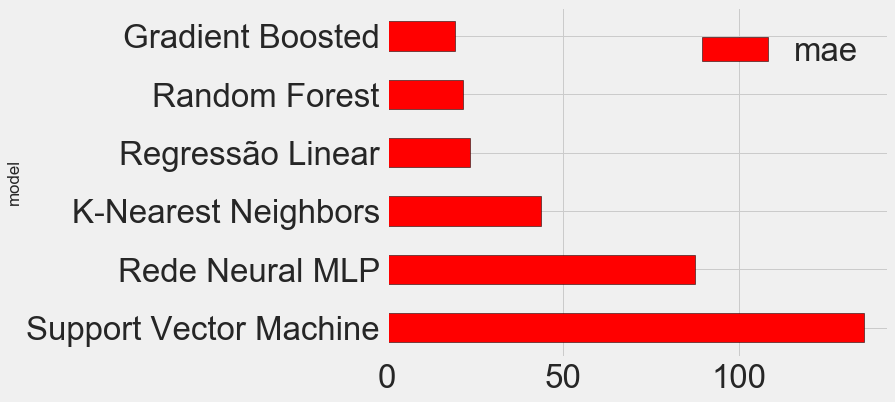

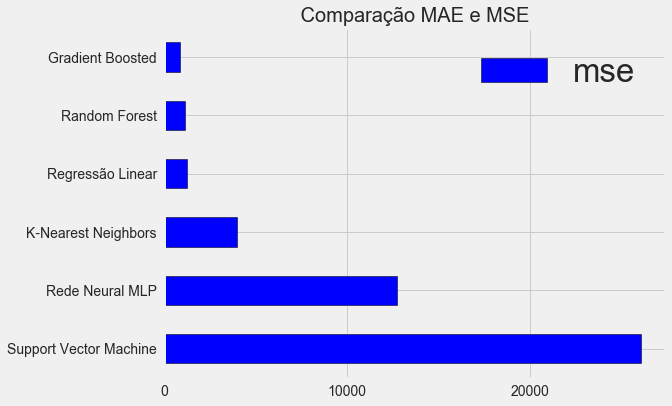

In [40]:
plt.style.use('fivethirtyeight')
figsize(8, 6)
# Dataframe para armazenar os resultados
modelos = pd.DataFrame({'model': ['Regressão Linear', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors','Rede Neural MLP'],
                                 'mae': [rl_mae, svr_mae, rf_mae, gb_mae, knr_mae, mlp_mae],
                                 'mse': [rl_mse, svr_mse, rf_mse, gb_mse, knr_mse, mlp_mse]})

# plots
modelos.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

modelos.sort_values('mse', ascending = False).plot(x = 'model', y = 'mse', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')
# axes
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel(''); plt.xticks(size = 14)
plt.title(' Comparação MAE e MSE ', size = 20);

-> Temos que o modelo com melhor desempenho (Menor _**MAE**_ e _**MSE**_) foi o GB - Gradient Boosting.
Logo, todo ferramental a seguir (Tuning e entendimento) será feito exclusivamente para tal modelo.

## Gradient Boosting

Aumento do Gradiente ou Gradient Boosting (GB) é também considerado um método ensemble baseado em árvores de regressão. Ele utiliza a técnica boosting, ao invés de bagging. A estratégia do boosting é uma melhoria do processo de bagging, a qual consiste em treinar diversos submodelos com amostras aleatórias no processo de treinamento e combiná-las para obter um desempenho menos “particularizado” e, consequentemente, com menos sobreajuste (overfiting). Em outras palavras, no GB, as árvores constituintes não possuem um mesmo peso na votação, isto é, a intenção principal do algoritmo é encontrar a combinação ótima de árvores com pesos.

## Tuning dos Parâmetros

Os algoritmos de AM possuem vários parâmetros que podem ser ajustados a fim de que o preditor tenha melhor aderência aos dados. Entretanto, essa tarefa de otimização é, na maioria dos casos, exploratória e o número de possíveis ajustes pode crescer exponencialmente na prática. 
Como por exemplo, para o modelo GB se tem como parâmetros tais atributos:

+ _**n_estimators**_: O número de arvores a serem geradas.
+ 	_**max_depth**_: Profundidade máxima da árvore.
+ _**min_samples_split**_: O número mínimo de amostras necessárias para dividir um nó interno.
+ _**min_samples_leaf**_: O número mínimo de amostras necessárias para estar em um nó da folha.
+ _**max_features**_: O número de variáveis a serem considerados ao procurar a melhor divisão.
+ _**loss**_: Função custo a ser otimizada.


Existe uma estratégia bastante interessante na literatura de AM chamada busca em grade (GridSearch), a qual testa todas essas possibilidades e retorna o melhor pipeline de AM. Entretanto, existem pesquisas que demonstram que a busca aleatória (Random Search), de um número limitado de possíveis pipelines de AM é mais eficiente e pode ter propriedades favoráveis quando comparada com a busca em grade. No algoritmo Random Search, estima-se um número k de iterações para a construção dos pipelines e, como resultado, é retornado o melhor pipeline nesse espaço. 

In [41]:
#função de perca a ser otimizada
loss = ['ls', 'lad', 'huber']
# Numero de arvores
n_estimators = [100, 500, 900, 1100, 1500]
# O número de variáveis a serem considerados ao procurar a melhor divisão 
max_features = ['auto', 'sqrt','log2',None]

# Profundidade máxima da árvore
max_depth = [2, 3, 5, 10, 15]

# O número mínimo de amostras necessárias para estar em um nó da folha
min_samples_leaf = [1, 2, 4, 6, 8]

#  número mínimo de amostras necessárias para dividir um nó interno
min_samples_split = [2, 4, 6, 10]

# Criando a random search
Parametros = {'loss': loss,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

### Random Search
Cross validation de 4, para 20 iterações

In [42]:
tuning = RandomizedSearchCV(estimator=gb,
                               param_distributions=Parametros,
                               cv=4, n_iter=20, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [43]:
tuning.fit(treino,y)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.1min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

os melhores parâmetros encontrado pelo Random Search

In [44]:
tuning.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### GridSearch

Aplicando o GridSearch com a configuração ótima do RandomSearch para procurar a melhor quantidade de arvóre

In [45]:
#Criar lista de arvores a serem testadas
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = tuning.best_estimator_

# Grid Search 
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [46]:
# treinando
grid_search.fit(treino, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   26.0s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=6,
                                                 min_samples_split=4,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500,
                                                 n_iter_no_change=None,
              

o melhor encontrado

In [47]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=350,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Default e Tunado

Criando modelos por Default e o melhor encontrado (ótimo), para realizar os plots de visualização, bem como entender o processo de entendimento do modelo

In [48]:
#modelo por default
gb = GradientBoostingRegressor()
default = gb.fit(treino, y)
default_result = default.predict(teste)

#modelo tunado
gbtuning = grid_search.best_estimator_
tunado = gbtuning.fit(treino, y)
tunado_result = tunado.predict(teste)

## Treino médio - 100 samples

Realizando o Treino com distribuição de 100 conjuntos aleatórios para treino e teste é possível averiguar qual o erro médio de acordo com a aleatoriedade dos dados de treino. Isto ajuda a entender o quão nosso problema é afetado pela escolha de tais dados, sendo que se a correlação der positiva, quer dizer que nosso problema pode ser bem generalizado. 

In [49]:
predicoes=[]
acurácia=[]
for i in range(0,100):
    predicoes.append([])
    trainX, testX, trainY, testY = train_test_split(treino, y, test_size=0.2)
    gbtuning.fit(trainX,trainY)
    predicoes_=gbtuning.predict(testX)
    acurácia.append(mae(testY,predicoes_))

plotando a distribuição da acurácia das 100 predições em log

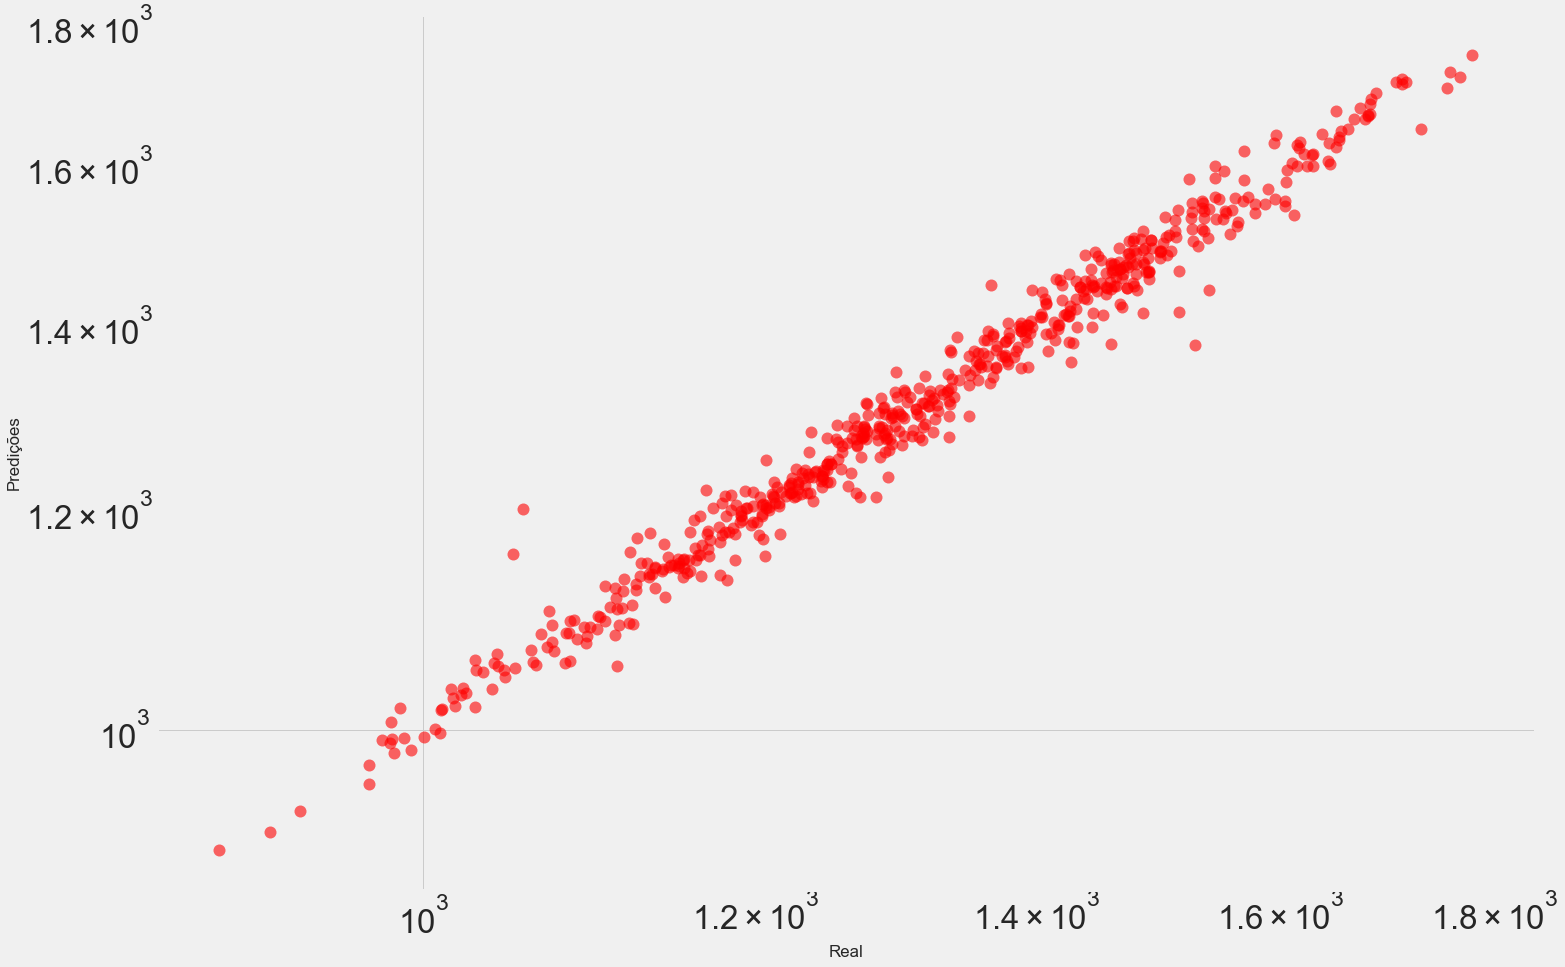

In [51]:
fig, axes = plt.subplots(figsize=(22, 15))
axes.set_xlabel("Real")
axes.set_ylabel("Predições")
axes.plot(testY,predicoes_,"o",markersize=12,color="red",alpha=0.6)
axes.set_xscale('log')
axes.set_yscale('log')


In [53]:
x=(np.array(predicoes_)-np.array(testY))
stats.kstest(x,'norm')

KstestResult(statistic=1.0, pvalue=0.0)

18.506767900014175 0.7548346578287013


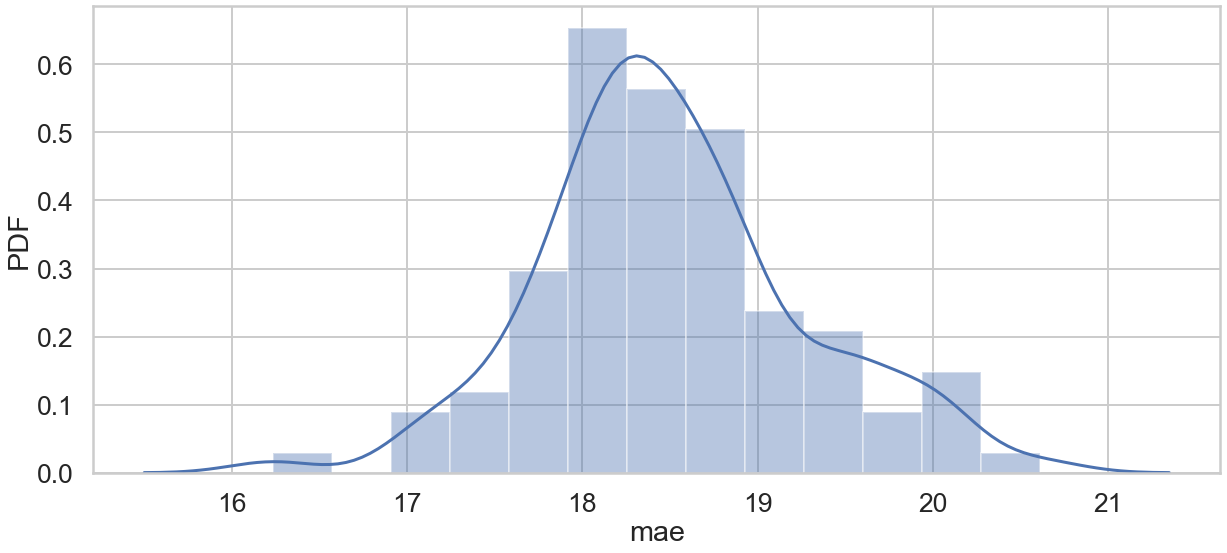

In [55]:
formatter = ticker.ScalarFormatter(useMathText=True)
plt.style.use('seaborn-notebook')
sns.set(style="whitegrid")
sns.set_context('poster',font_scale=1.2)
#Tela vazia de 1 por 2 subplots
fig, axes = plt.subplots(figsize=(18, 8))
axes.set_ylabel("PDF")
axes.set_xlabel("mae")
sns.distplot(acurácia,kde=True)
#ax.set_yscale("log")
print(np.mean(acurácia),np.std(acurácia))

* Resultados do modelo **DEFAULT** e **TUNADO**

In [56]:
print('Performance modelo padrao no dataset de teste:   MAE = %0.4f.' % mae(y_test, default_result))
print('Performance melhor modelo no dataset de teste:   MAE = %0.4f.' % mae(y_test, tunado_result))

Performance modelo padrao no dataset de teste:   MAE = 19.3158.
Performance melhor modelo no dataset de teste:   MAE = 18.4658.


In [57]:
print('Performance modelo padrao no dataset de teste:   MSE = %0.4f.' % mse(y_test, default_result))
print('Performance melhor modelo no dataset de teste:   MSE = %0.4f.' % mse(y_test, tunado_result))

Performance modelo padrao no dataset de teste:   MSE = 861.9418.
Performance melhor modelo no dataset de teste:   MSE = 744.1459.


In [58]:
print('MAPE TUNING %: ',(mae(y_test[:], tunado_result[:]))/y_test[:].mean()*100)
print('MAPE DEFAULT %: ',(mae(y_test[:], default_result[:]))/y_test[:].mean()*100)

MAPE TUNING %:  Consumo Elétrico (GWh)    1.38857
dtype: float64
MAPE DEFAULT %:  Consumo Elétrico (GWh)    1.452493
dtype: float64


In [59]:
print('PRECISÃO TUNING %: ',100 - (mae(y_test[:], tunado_result[:]))/y_test[:].mean()*100)
print('PRECISÃO DEFAULT %: ',100 - (mae(y_test[:], default_result[:]))/y_test[:].mean()*100)

PRECISÃO TUNING %:  Consumo Elétrico (GWh)    98.61143
dtype: float64
PRECISÃO DEFAULT %:  Consumo Elétrico (GWh)    98.547507
dtype: float64


## PLOTS dos Resultados

* Observar qual o erro de acordo com o número de árvores do modelo, para os dados de teste e treino

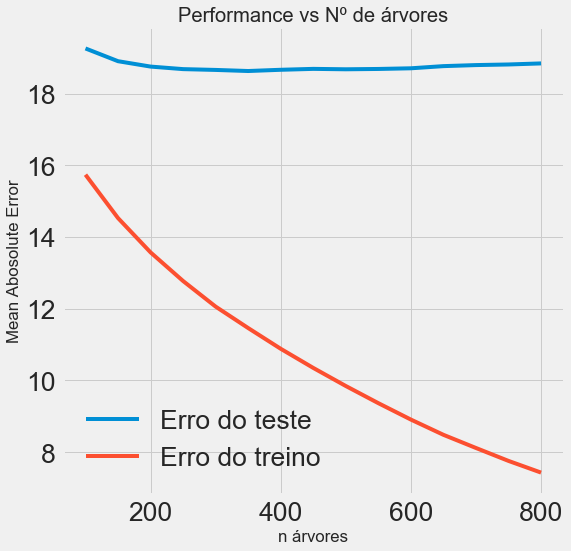

In [60]:
# colando os resultados do gridsearch em dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot 
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Erro do teste')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Erro do treino')
plt.xlabel('n árvores'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Nº de árvores');

adequando os dados para plotar

In [61]:
target= y_test.reset_index()
del target['index']
real = pd.DataFrame(target)
default = pd.DataFrame(default_result)
tunado = pd.DataFrame(tunado_result)

residuodefault = real['Consumo Elétrico (GWh)'] - default[0]
residuotunado = real['Consumo Elétrico (GWh)'] - tunado[0]

* Exemplo comparação entre o predito pelo modelo default, o ótimo encontrado e o real

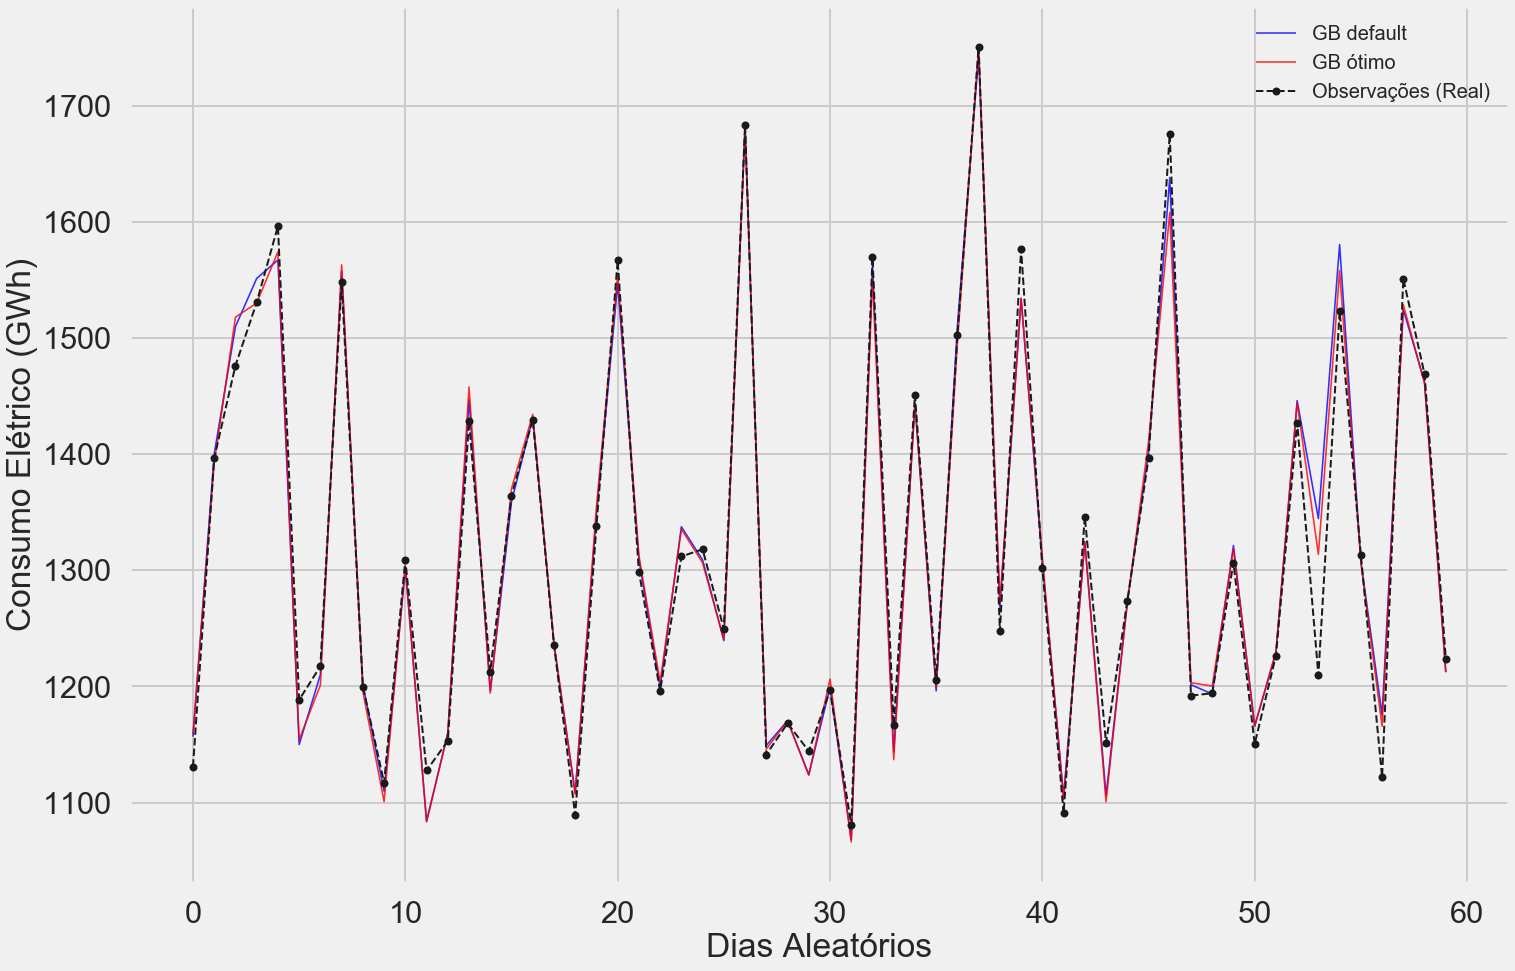

In [62]:
plt.style.use('seaborn-notebook')
sns.set_context('poster',font_scale=1.4)
fig, axes = plt.subplots(figsize=(22, 15))

#horizonte das predições
horizonte = 60

axes.yaxis.set_major_formatter(formatter) 
plt.plot(default[:horizonte], color='blue', lw=1.6, alpha=0.8,label='GB default')
plt.plot(tunado[:horizonte], color='red', lw=1.6, alpha=0.8,label='GB ótimo')
plt.plot(real[:horizonte], color='k',markersize=8,marker='o', lw=2, linestyle='dashed',label='Observações (Real)')

plt.legend(loc='best', fontsize=20)
axes.set(ylabel="Consumo Elétrico (GWh)", xlabel="Dias Aleatórios")
plt.show()

* Gráfico de Resíduos

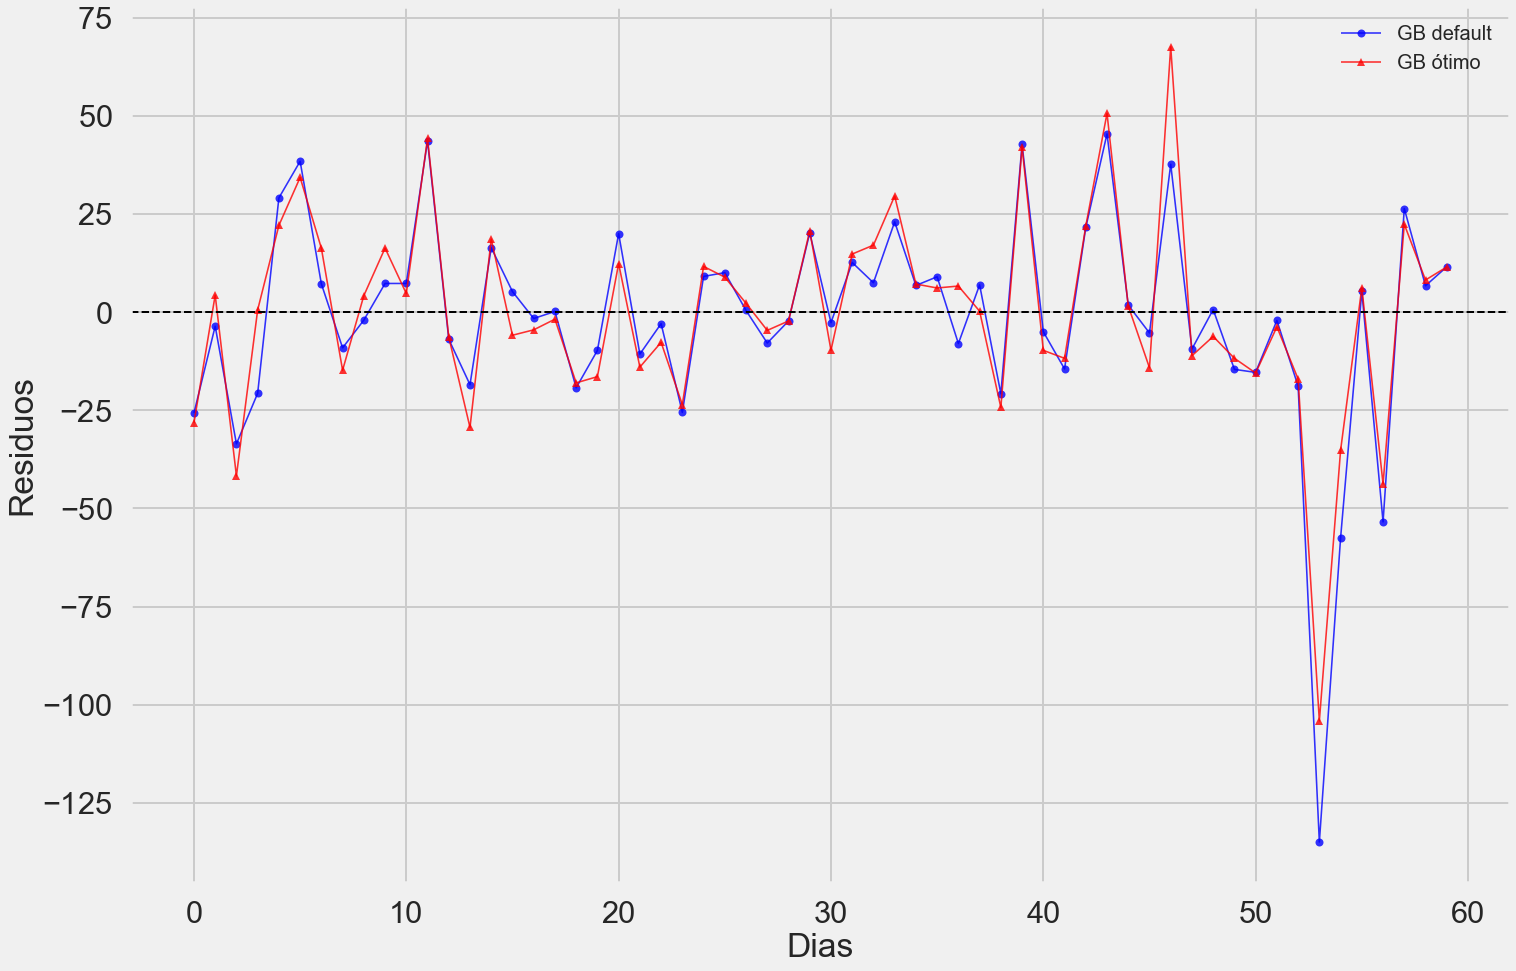

In [63]:
sns.set_context('poster',font_scale=1.4)
fig, axes = plt.subplots(figsize=(22, 15))
axes.yaxis.set_major_formatter(formatter) 
horizonte = 60
plt.plot(residuodefault[:horizonte], color='blue', markersize=8,marker='o',lw=1.6, alpha=0.8,label= 'GB default')
plt.plot(residuotunado[:horizonte], color='red',markersize=8,marker='^', lw=1.6, alpha=0.8,label='GB ótimo')
plt.axhline(0, color='black',lw=2,linestyle='dashed') 
plt.legend(loc='best', fontsize=20)
axes.set(ylabel="Residuos", xlabel="Dias")
plt.show()

* Histograma de distribuição dos resíduos 

É possível observar que o erro fica entre -50 a 50 GWh

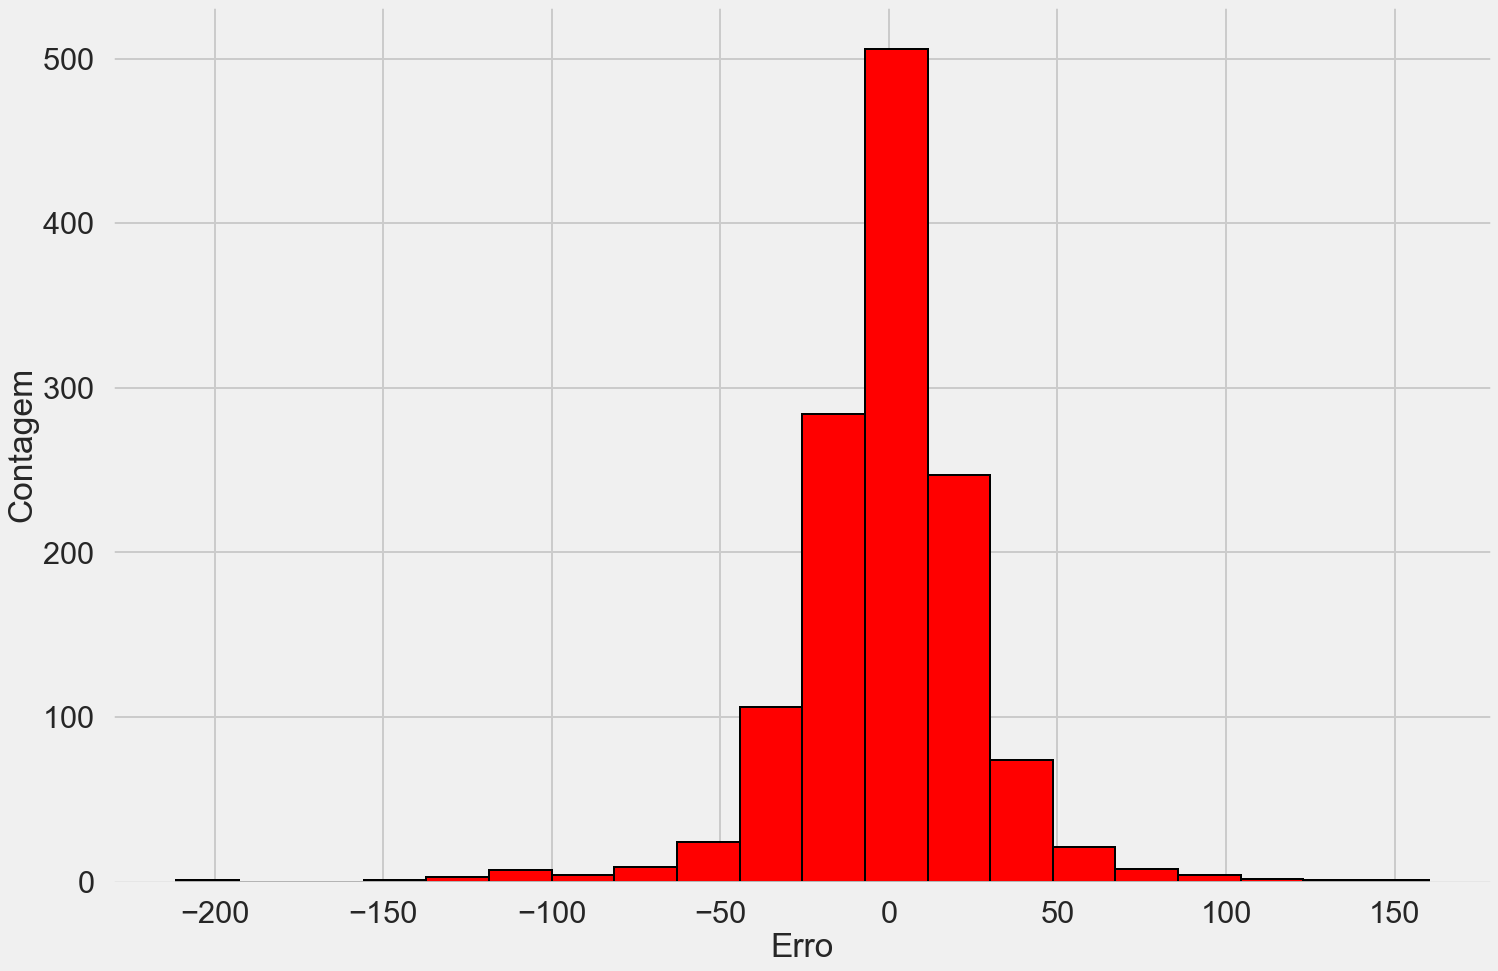

In [64]:
sns.set_context('poster',font_scale=1.4)
fig, axes = plt.subplots(figsize=(22, 15))
axes.yaxis.set_major_formatter(formatter) 
horizonte = 60
plt.hist(residuotunado[:], color = 'red', bins = 20,
         edgecolor = 'black')
axes.set(ylabel="Contagem", xlabel="Erro")
plt.show()

* ScatterPlot dos resíduos

Como os dados foram serapados aleatoriamente, não há correlação entre os erros

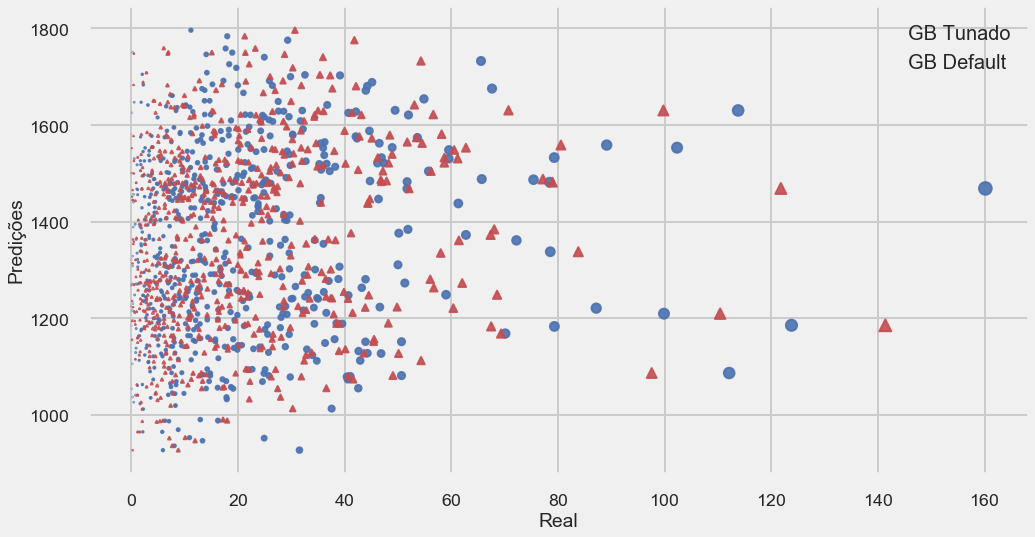

In [65]:
plt.style.use('seaborn-notebook')
sns.set_context('poster',font_scale=0.8)

fig, axes = plt.subplots(figsize=(15, 8))
axes.yaxis.set_major_formatter(formatter) 
axes.xaxis.set_major_formatter(formatter) 

plt.scatter(residuotunado[:],real[:],s=residuotunado,c='b',marker='o',alpha=0.9,label='GB Tunado')
plt.scatter(residuodefault[:],real[:],s=residuodefault,c='r',marker='^' ,alpha=0.9,label='GB Default')
plt.legend(loc='best', fontsize=20)
axes.set(ylabel="Predições", xlabel="Real")
plt.show()


* densidade entre predições do ótimo, default e real

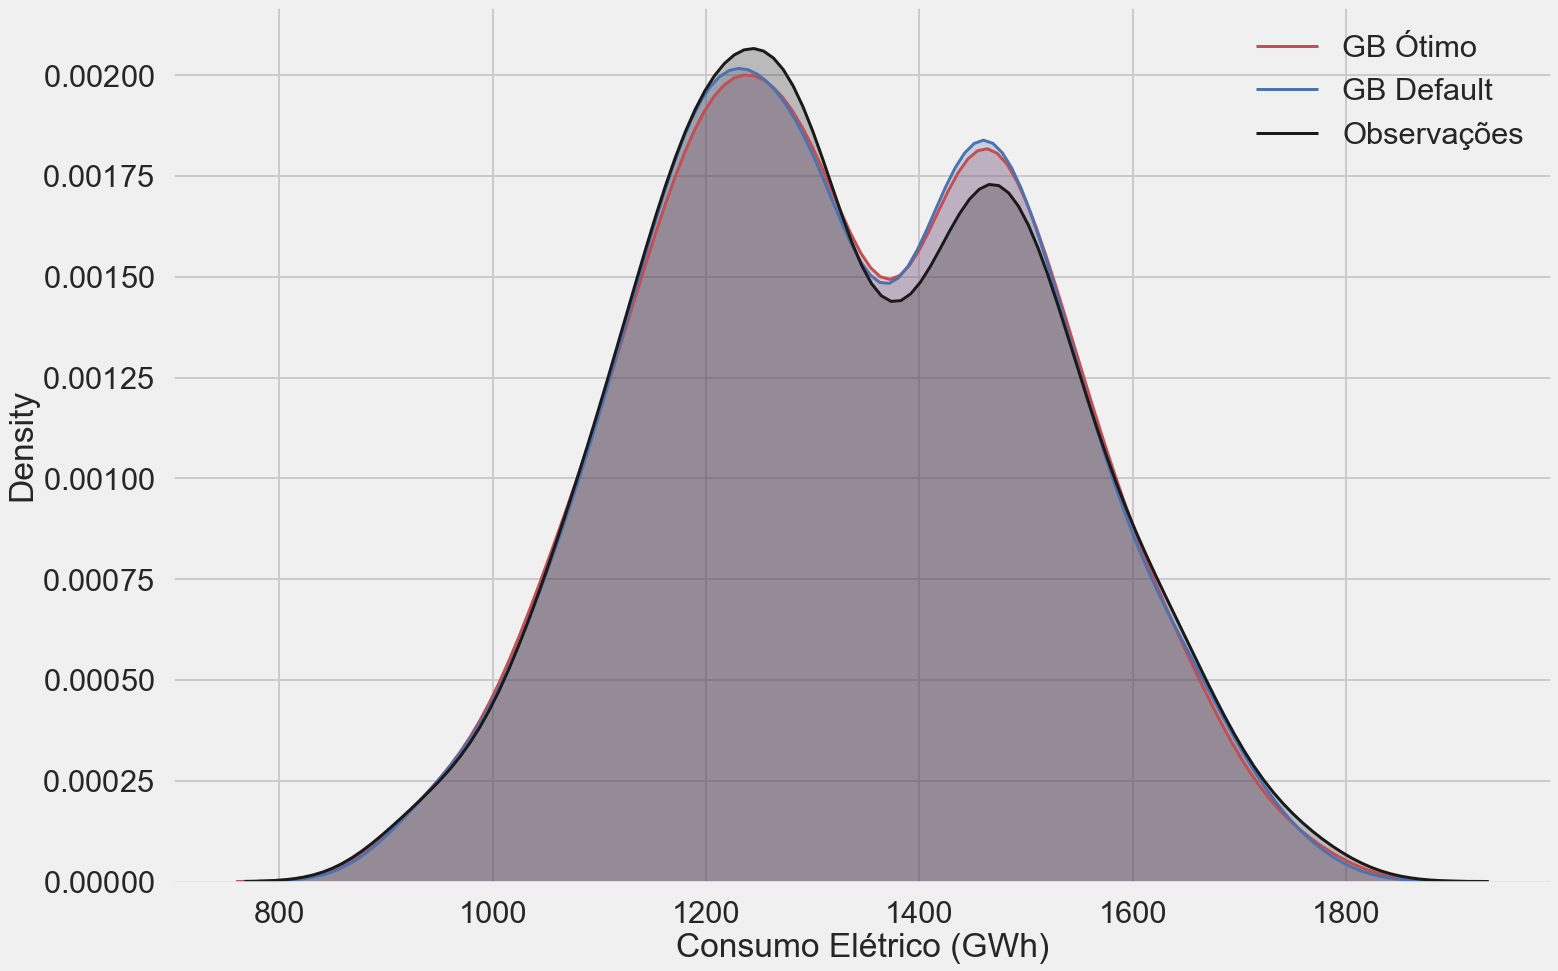

In [66]:
sns.set_context('poster',font_scale=1.4)
fig, axes = plt.subplots(figsize=(22, 15))
axes.yaxis.set_major_formatter(formatter) 
# Density plot 
sns.kdeplot(tunado[0], label = 'GB Ótimo',shade=True, color="r")
sns.kdeplot(default[0], label = 'GB Default',shade=True, color="b")
sns.kdeplot(y_test['Consumo Elétrico (GWh)'], label = 'Observações',shade=True, color="k")

# Label plot
plt.xlabel('Consumo Elétrico (GWh)'); plt.ylabel('Density');
plt.title('');

### Entendendo o Modelo

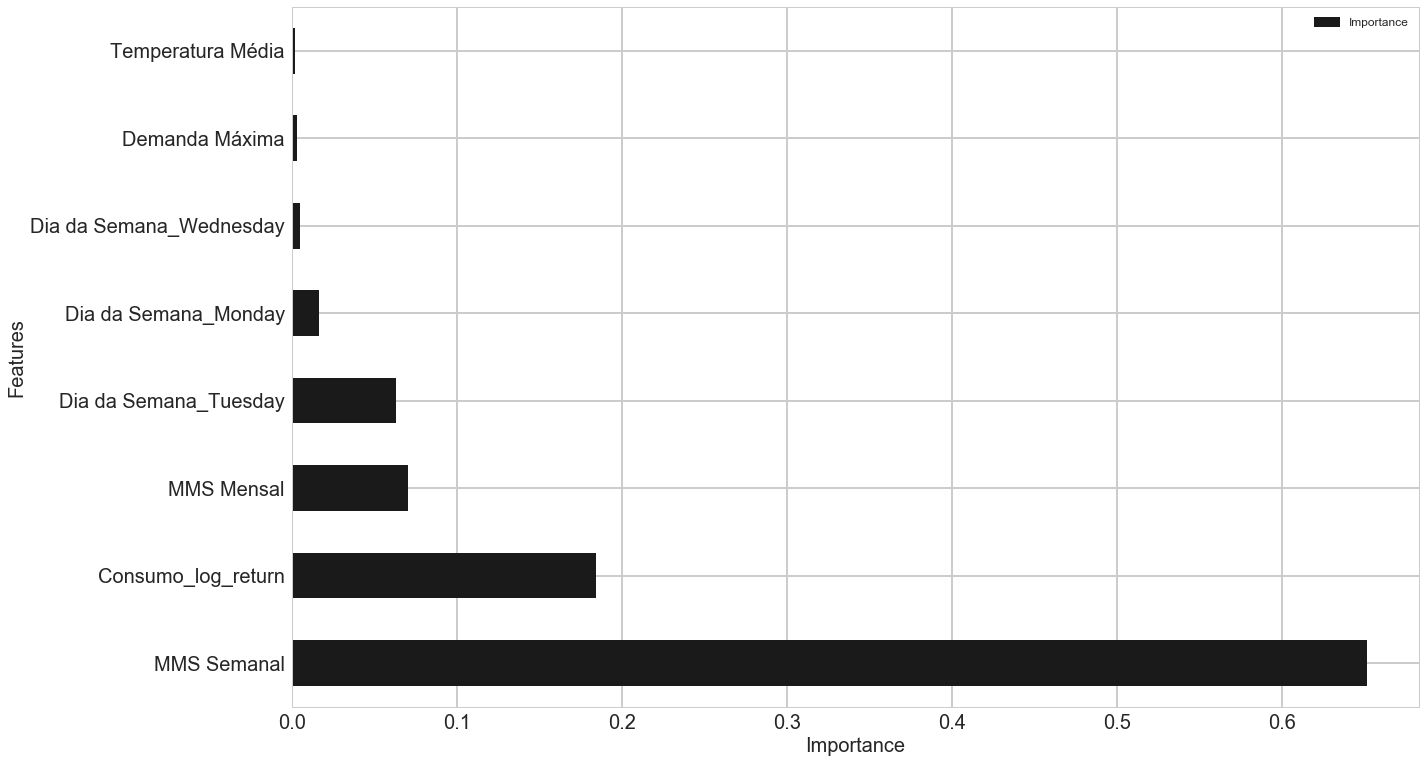

In [67]:
# Extraindo as feature importances em um dataframe
feature_results = pd.DataFrame({'feature': list(features.columns), 
                                'Importance': gbtuning.feature_importances_})

# Mostrando as 10 mais relevantes
feature_results = feature_results.sort_values('Importance', ascending = False).reset_index(drop=True)

figsize(18, 12)
plt.style.use('seaborn-whitegrid')

# Plotando as 10 features mais importantes
feature_results.loc[:7, :].plot(x = 'feature', y = 'Importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'k', fontsize=20);
plt.xlabel('Importance', size = 20); plt.ylabel('Features',size=20)
plt.legend(loc='best', fontsize=12)

* É possível verificar que as vars criadas (Média móvel semanal e log_return) foram as vars com maior peso na podenração do modelo

### Locally Interpretable Model-agnostic Explanations - LIME

In [68]:
# Encontrando os residuos e alterando a dimensao de y_test
y_test = np.array(y_test).reshape((-1,))
residuals = abs(tunado_result - y_test)

#pegando a decisão da pior e da melhor predição feita
errado = teste[np.argmax(residuals), :]
certo = teste[np.argmin(residuals), :]

In [69]:
# Criando um objeto tipo lime explainer
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = treino, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(feature_results['feature'][:]))

* pior predição

Predição: 1388.7176
Valor real: 1245.5769


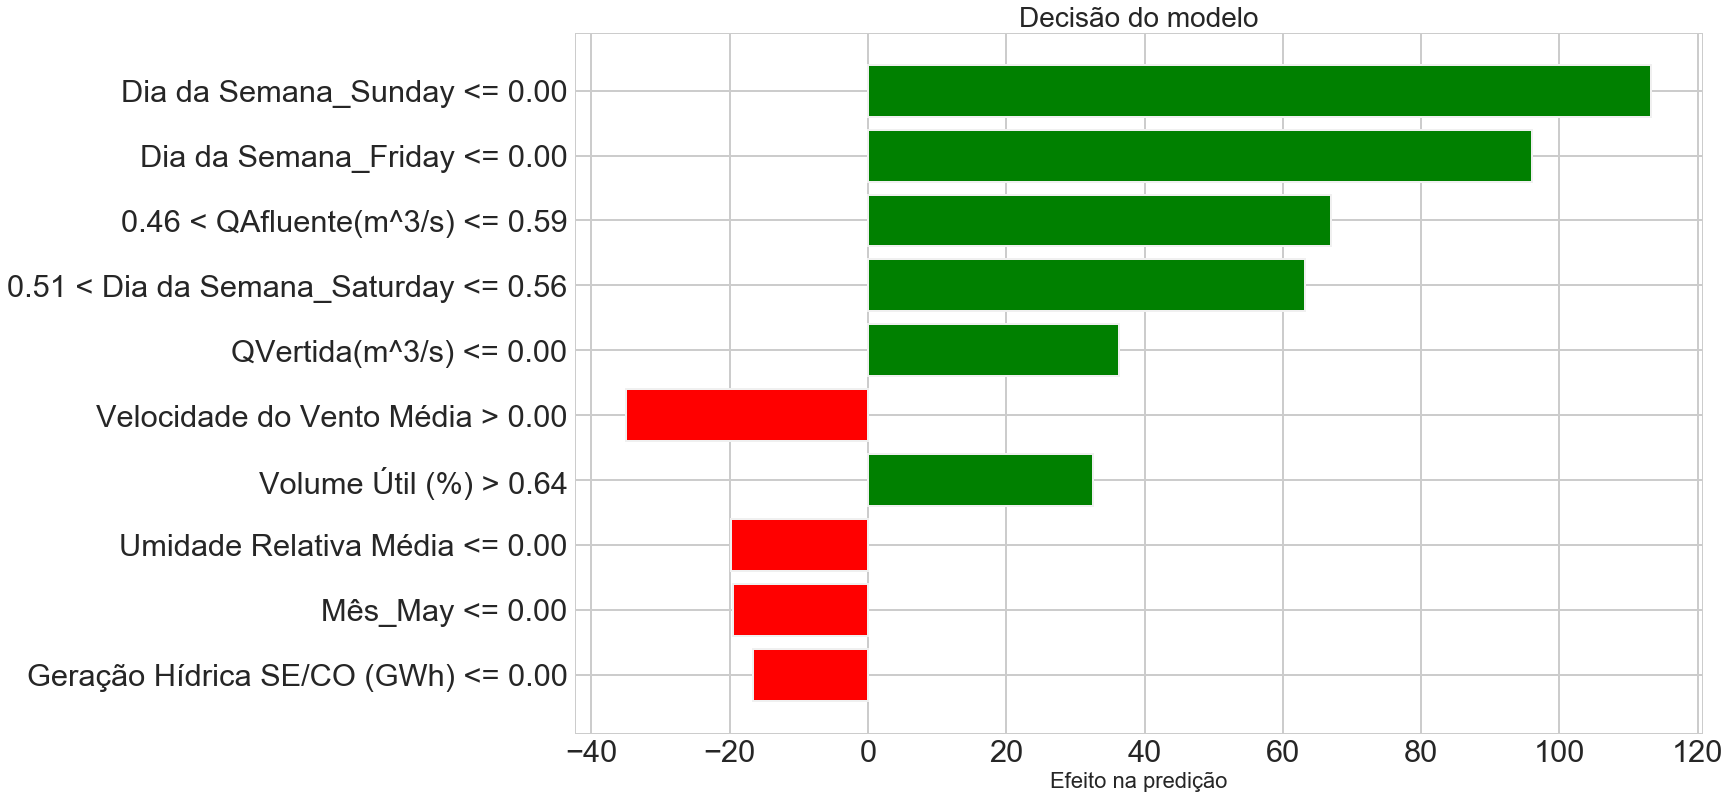

In [70]:
figsize(18, 12)
plt.style.use('seaborn-whitegrid')
# print da diferença
print('Predição: %0.4f' % gbtuning.predict(errado.reshape(1, -1)))
print('Valor real: %0.4f' % y_test[np.argmax(residuals)])

# para a predição errada
wrong_exp = explainer.explain_instance(data_row = errado, 
                                       predict_fn = gbtuning.predict)

# Plot
wrong_exp.as_pyplot_figure();
plt.title('Decisão do modelo', size = 28);
plt.xlabel('Efeito na predição', size = 22);

* melhor predição

Predição: 1400.0144
Valor Real: 1399.9185


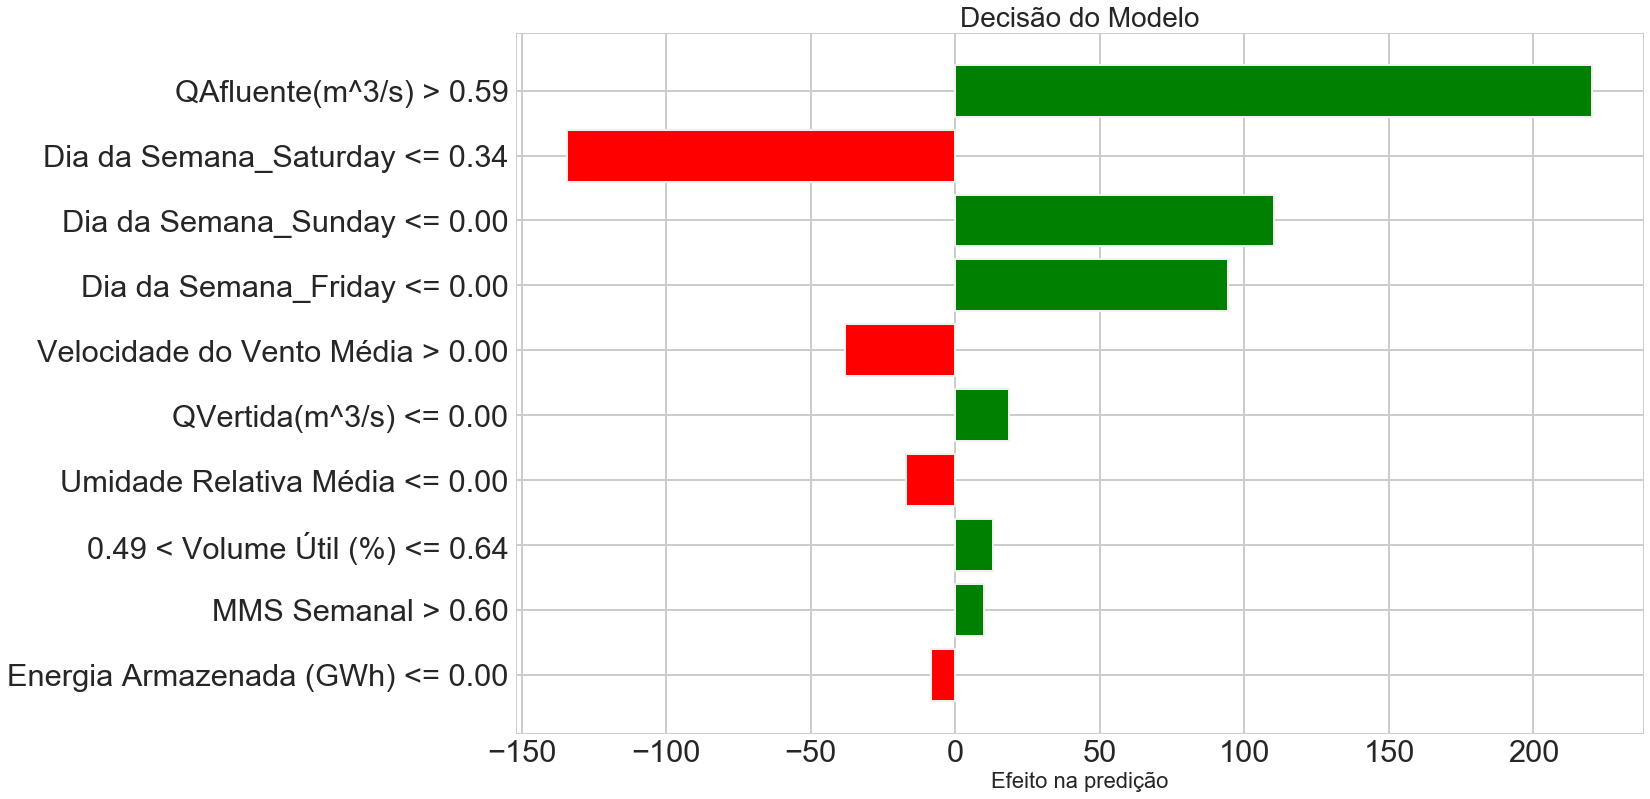

In [71]:
figsize(18, 12)
plt.style.use('seaborn-whitegrid')
# Display da certa
print('Predição: %0.4f' % gbtuning.predict(certo.reshape(1, -1)))
print('Valor Real: %0.4f' % y_test[np.argmin(residuals)])

# Explicação
right_exp = explainer.explain_instance(certo, gbtuning.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Decisão do Modelo', size = 28);
plt.xlabel('Efeito na predição', size = 22);

# Conclusão 

## O que foi realizado: 

*  Construção da base de dados brasileira composta por dados do Operador Nacional do Sistema (ONS) e do Instituto Nacional de Meteorologia (INMET), sendo este dataset um conjunto de dados inédito dentro do contexto de predição energética.
* Aplicação do processo da Descoberta de Conhecimento (Knowledge Data Discovery), onde foi possível compreender e analisar, de forma quantitativa, todo o comportamento das variáveis presentes na base de dados investigada, bem como ainda eliminar as anomalias contidas neste.
* Engenharia de recursos a fim de criar novas variáveis a partir das já existentes, o que possibilitou originar e introduzir “novas” informações aos modelos de ML estudados, o que fez com que estes se ajustassem para melhorar sua capacidade de regressão e previsibilidade.
* Implementação computacional das seguintes metodologias de Aprendizado de Máquina: Regressão linear, KNeighborRegressor, Random Forest, Gradient Boosting, Suppot Vector Machine e Rede Neural MLP.
* Tuning dos parâmetros do modelo Gradient Boosting, bem como visualização dos resultados e entendimento da tomada de decisão do mesmo.

## Resultados Obtidos:

* O modelo que obteve melhor desempenho no quesito precisão foi o Gradient Boosting, 98.61% de precisão com o modelo ótimo
* Tal grau elevado de assertividade pode ser justificado devido à natureza da variável target. Analisando o resultado do gráfico QQ-Plot, que retornou um coeficiente de determinação de 0,9928 entre as distribuições de probabilidade dos quartis, o consumo de eletricidade é bem homogêneo e não volátil em detrimento à fatores externos, tendo uma “boa” relação com as variáveis fundamentais presentes na base de dados como, por exemplo, a variável dia da semana.
* Eficácia das variáveis artificiais criadas a partir da engenharia de recursos, sendo que estas foramconsideradas com elevado grau de importância na ponderação dos modelos (Log_return e média móvel semanal)

## Próximos Passos:

* Utilização dos modelos XGboost e Ada boost, que são melhorias do Gradient Boosting, além da implementação da rede neural LSTM (Long-Short-Term-Memory)
* Atualização da base de dados, implementar dados de 2019.
